## Проект: вариант 3

Представьте, что вы работаете в крупном дейтинговом приложении.

Помимо базовых функций, в приложении также имеется премиум-подписка, которая дает доступ к ряду важных дополнительных возможностей. Был проведен A/B тест, в рамках которого для новых пользователей из нескольких стран была изменена стоимость премиум-подписки* при покупке через две новые платежные системы. При этом стоимость пробного периода оставалась прежней.

Проверьте:

    Был ли эксперимент успешен в целом.
    Проанализируйте, имеет ли нововведение смысл среди каких-либо конкретных групп пользователей.

*Деньги за подписку списываются ежемесячно до тех пор, пока пользователь её не отменит.

Данные

Всего есть три группы: тестовая (test), контрольная 1 (control_1) и контрольная 2 (control_2). Для каждой из них:

users_*.csv – информация о пользователях:

    uid – идентификатор пользователя
    age – возраст
    attraction_coeff – коэффициент привлекательности (от 0 до 1000, \frac{лайки}{просмотры}*1000просмотрылайки​∗1000)
    coins – число монеток (внутренняя валюта)
    country – страна  
    visit_days – в какие дни после регистрации пользователь посещал приложение (напр. в 1, затем в 7)
    gender – пол
    age_filter_start  – фильтр поиска, мин. значение 
    age_filter_end  – фильтр поиска, макс. значение 
    views_count – число полученных оценок 
    was_premium – был ли когда-либо премиум (либо пробный период премиум-статуса, либо купленный за деньги)
    is_premium –  является ли премиум
    total_revenue – нормированная выручка
     

transactions_*.csv – информация о платежах пользователей:

    uid – идентификатор пользователя
    country – страна
    joined_at – дата и время регистрации
    paid_at – дата и время покупки
    revenue – нормированная выручка
    payment_id – идентификатор платежа
    from_page – откуда пользователь перешел на страницу оплаты
    product_type – тип продукта (trial_premium – пробная премиум-подписка, premium_no_trial – премиум-подписка без пробной, coins – подписка за внутреннюю валюту, other_type – другое)
     

Файлы:

    users_test – информация о пользователях в тестовой группе. 
    users_control_1 – информация о пользователях в первой контрольной группе. 
    users_control_2 – информация о пользователях во второй контрольной группе . 
    transactions_test – информация о платежах пользователей в тестовой группе. 
    transactions_control_1 – информация о платежах пользователей в первой контрольной группе. 
    transactions_control_2 – информация о платежах пользователей во второй контрольной группе 

Приступим.
Первым делом подгрузим имеющиемся данные, посмотрим описательные характеристики, проведем предобработку, проверим, присутствуют ли пропущенные значения в данных, поменяем типы данных, если это необходимо.

In [1]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from urllib.parse import urlencode
from datetime import timedelta
import requests
import warnings
warnings.filterwarnings('ignore')

from scipy import stats
from scipy.stats import f_oneway, norm, mannwhitneyu, chi2_contingency, shapiro
import pingouin as pg
from statsmodels.stats.proportion import proportions_ztest

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

In [2]:
ut = pd.read_csv(r'Проект_3_users_test.csv', sep = ';')
uc1 = pd.read_csv(r'Проект_3_users_control_1.csv', sep = ';')
uc2 = pd.read_csv(r'Проект_3_users_control_2.csv', sep = ';')
tt = pd.read_csv(r'Проект_3_transactions_test.csv', sep = ';')
tc1 = pd.read_csv(r'Проект_3_transactions_control_1.csv', sep = ';')
tc2 = pd.read_csv(r'Проект_3_transactions_control_2.csv', sep = ';')

Рассмотрим сначала представленную информацию о пользователях.

In [3]:
print (ut.head(), '\n')
print (ut.info(), '\n')
print (ut.isnull().sum(), '\n')
print ('Уникальных UID:', ut.uid.nunique())

         uid  age  attraction_coeff  coins                   country  \
0  892309896   27               685    NaN  United States of America   
1  892044516   27                 0    NaN                   Germany   
2  892185708   45                44    NaN                    Israel   
3  892130292   32                 0    NaN  United States of America   
4  891406035   27              1000    NaN                    France   

                                          visit_days  gender  \
0                   1,2,3,4,5,6,7,8,9,10,11,12,16,17       1   
1                                                NaN       1   
2  1,3,4,6,7,8,10,11,12,13,14,15,16,17,18,19,20,2...       1   
3                         1,2,3,4,5,6,7,8,9,10,11,12       1   
4                                                NaN       1   

   age_filter_start  age_filter_end  views_count  was_premium  is_premium  \
0                24              30           89          NaN         NaN   
1                24         

In [4]:
print (uc1.head(), '\n')
print (uc1.info(), '\n')
print (uc1.isnull().sum(), '\n')
print ('Уникальных UID:', uc1.uid.nunique())

         uid  age  attraction_coeff  coins                   country  \
0  892319115   25               435    NaN  United States of America   
1  891248523   29               500    NaN  United States of America   
2  891670932   33               800    NaN                    France   
3  891060786   26                 0    NaN                 Argentina   
4  892006554   35               294    NaN  United States of America   

                          visit_days  gender  age_filter_start  \
0                        1,2,3,4,5,6       0                22   
1                                1,2       1                26   
2             1,2,3,5,6,8,9,11,13,16       1                30   
3                          1,2,3,4,5       1                23   
4  1,2,3,5,6,7,8,9,10,12,15,16,17,19       1                30   

   age_filter_end  views_count  was_premium  is_premium  total_revenue  
0              32          982          NaN         NaN              0  
1              32       

In [5]:
print (uc2.head(), '\n')
print (uc2.info(), '\n')
print (uc2.isnull().sum(), '\n')
print ('Уникальных UID:', uc2.uid.nunique())

         uid  age  attraction_coeff  coins                   country  \
0  892035504   37               137    NaN                    Israel   
1  891782112   57                 0    NaN                     Italy   
2  891110337   30               769    NaN                    France   
3  891796320   48               750    NaN                    France   
4  891880212   54               638    NaN  United States of America   

                     visit_days  gender  age_filter_start  age_filter_end  \
0       1,2,3,4,5,6,7,8,9,11,13       1                30              40   
1                             1       1                54              60   
2                     1,2,3,4,5       1                27              33   
3  1,4,6,8,10,11,12,14,15,16,18       1                45              51   
4                             1       1                35              53   

   views_count  was_premium  is_premium  total_revenue  
0           51          NaN         NaN        

По результатам анализа информации о юзерах можно сделать вывод, что во всех трех группах есть пустые значения в столбцах:
- coins - число монеток (внутренняя валюта): пропущенные значения явно свидетельствуют о том, что пользователи не приобретали внутреннюю валюту, следовательно, их можно занулить (0)
- visit_days - дни посещения приложения: по аналогии, пропущенные значения могут означать, что пользователь не заходил в приложение после регистрации (0)
- was_premium - был ли когда-либо куплен премиум: т.к. сейчас заполнена информация (1) по тем пользователям, которые когда-либо приобретали премиум аккаунт, следовательно, пустые значения можно заменить на (0), т.е. эти пользователи не приобретали премиум подписку
- is_premium - является ли премиум аккаунтом: по аналогии с предыдущим пунктом, пользователи, которые находятся на премиум подписки обозначены (1), следовательно пустые значения можно заменить на (0), т.е. эти пользователи сейчас не пользуются премиум подпиской

In [6]:
ut[['coins','was_premium','is_premium']] = ut[['coins','was_premium','is_premium']].fillna(0)
ut['visit_days'] = ut['visit_days'].fillna(0)

uc1[['coins','was_premium','is_premium']] = uc1[['coins','was_premium','is_premium']].fillna(0)
uc1['visit_days'] = uc1['visit_days'].fillna(0)

uc2[['coins','was_premium','is_premium']] = uc2[['coins','was_premium','is_premium']].fillna(0)
uc2['visit_days'] = uc2['visit_days'].fillna(0)

In [7]:
print('Дубликаты в users_test:     ', ut.duplicated().sum())
print('Дубликаты в users_control_1:', uc1.duplicated().sum())
print('Дубликаты в users_control_2:', uc2.duplicated().sum())

Дубликаты в users_test:      0
Дубликаты в users_control_1: 0
Дубликаты в users_control_2: 0


Построим различные визуализации для анализа информации о пользователях:

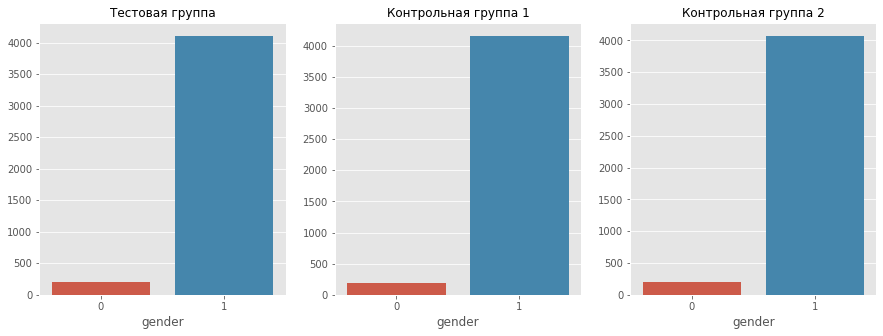

In [8]:
# построим график распределения числа пользователей по полу
plt.figure(figsize = (15, 5))

plt.subplot(1, 3, 1)
plt.title('Тестовая группа', fontsize = 12)
sns.countplot(x = ut.gender)
plt.ylabel('')

plt.subplot(1, 3, 2)
plt.title('Контрольная группа 1', fontsize = 12)
sns.countplot(x = uc1.gender)
plt.ylabel('')

plt.subplot(1, 3, 3)
plt.title('Контрольная группа 2', fontsize = 12)
sns.countplot(x = uc2.gender)
plt.ylabel('')
    
plt.show()

Достаточно большой процент пользователей приложения является представителями одного пола. По статистике мужчины являются наиболее активными пользователями дейтинговых приложений. Количество мужчин и женщин в группах распределены равномерно. Соответственно, выборки по половому признаку  можно считать репрезентативными.

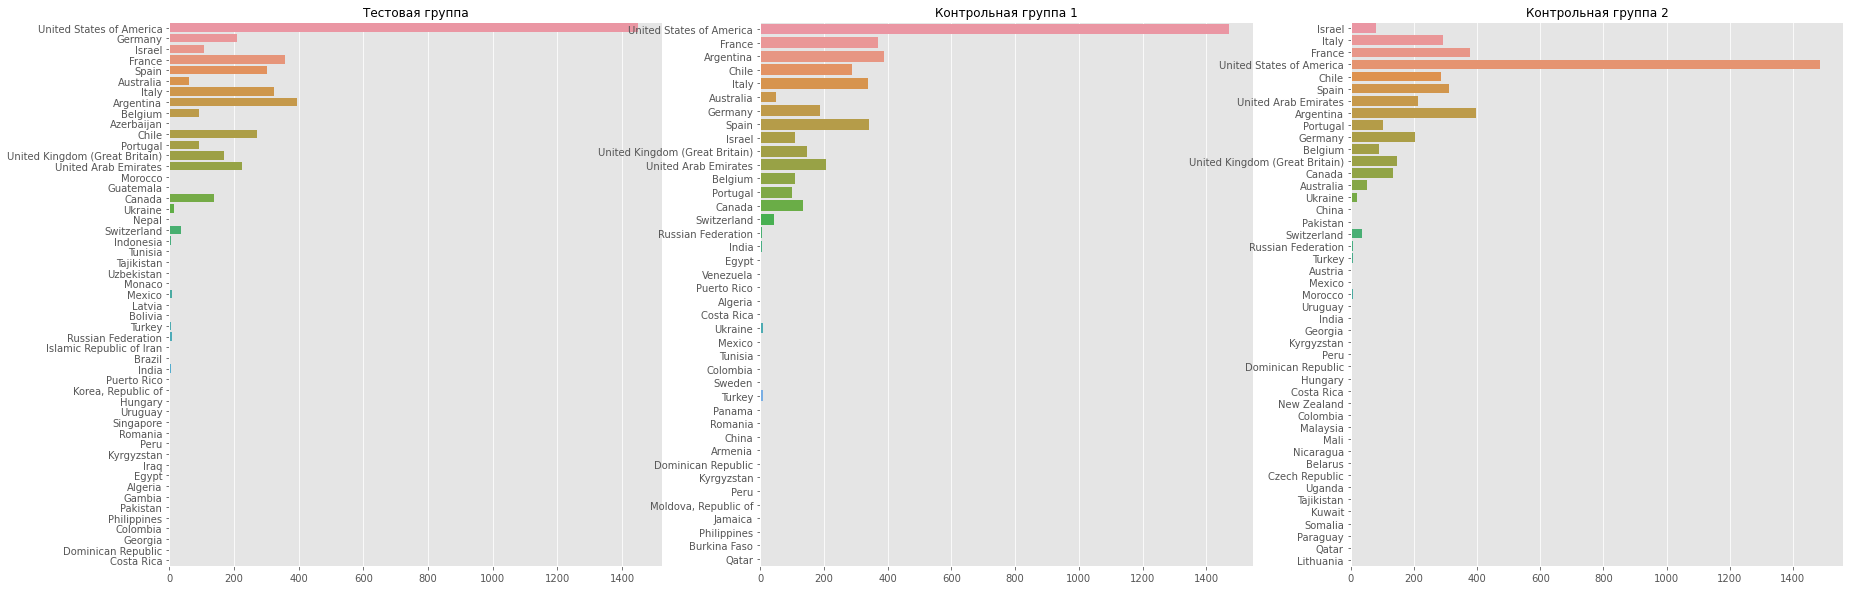

In [9]:
# визуализация юзеров приложения по странам
plt.figure(figsize = (30, 10))

plt.subplot(1, 3, 1)
plt.title('Тестовая группа', fontsize = 12)
sns.countplot(y = ut.country)
plt.xlabel('')
plt.ylabel('')

plt.subplot(1, 3, 2)
plt.title('Контрольная группа 1', fontsize = 12)
sns.countplot(y = uc1.country)
plt.xlabel('')
plt.ylabel('')

plt.subplot(1, 3, 3)
plt.title('Контрольная группа 2', fontsize = 12)
sns.countplot(y = uc2.country)
plt.xlabel('')
plt.ylabel('')

plt.show()

Подавляющее большинство пользователей приложения являются жителями США. Количество пользователей по страновому признаку распределено равномерно в тестовой и контрольных группах. Следовательно, выборки репрезентативны.

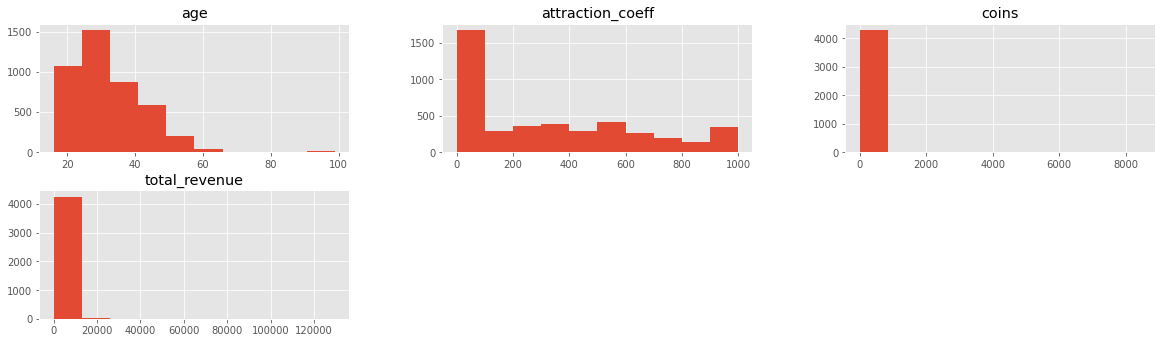

In [10]:
# визуализация количественных переменных (тестовая группа)
quantitative = ['age', 'attraction_coeff', 'coins', 'total_revenue']
ut[quantitative].hist(figsize = (20, 8.5), layout = (3, 3))

plt.show()

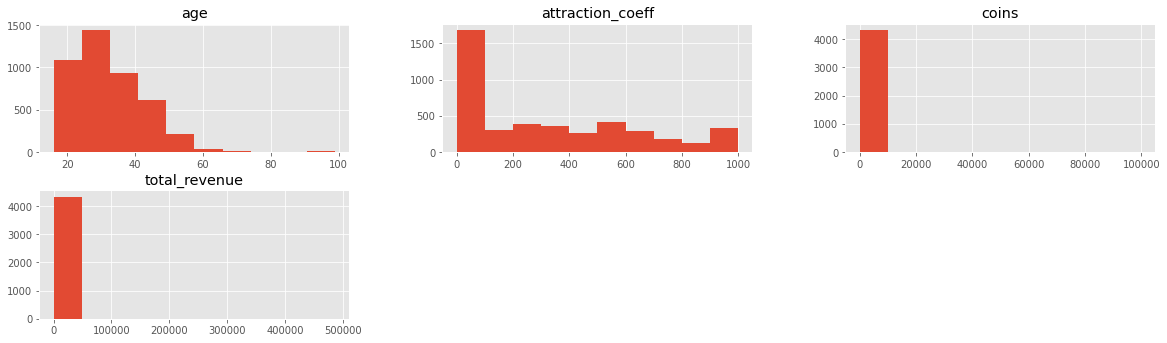

In [11]:
# визуализация количественных переменных (контрольная группа 1)
uc1[quantitative].hist(figsize = (20, 8.5), layout = (3, 3))

plt.show()

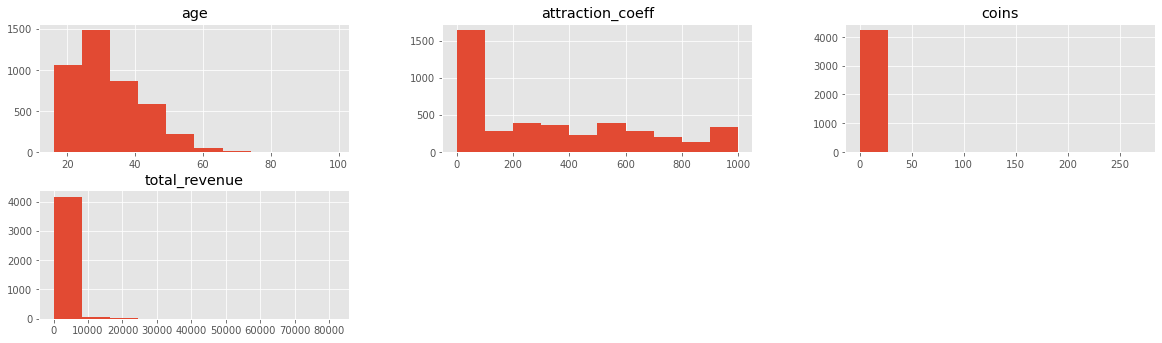

In [12]:
# визуализация количественных переменных (контрольная группа 2)
uc2[quantitative].hist(figsize = (20, 8.5), layout = (3, 3))

plt.show()

Возраст: приложением активно пользуются молодые люди в возрасте от 20 до 35 лет. Распределение пользователей в группах по возрастному признаку практически индентично. Средний возраст во всех группах составляет 32 года.
\
\
Коэффициент привлекательности: коэффициенты во всех трех группах распределены равномерно. Стоит отметить, что большинство анкет имеют нулевую привлекательность. Возможно это связано с фейковыми профилями либо малым количеством просмотров из-за неполноты заполненных данных.
\
\
Число монеток: во всех трех группах распределено равномерно, большинство пользователей не покупают внутреннюю валюту. Возможно стоит подумать над промоакцией, чтобы стимулировать эффект от продажи монеток.
\
\
Выручка: показатели также распределены достаточно равномерно в тестовой и контрольных группах. Средняя выручка равна 510.

In [13]:
# сводная статистика для выводов после предобработки данных (тестовая группа)
ut.describe().round(1)

,uid,age,attraction_coeff,coins,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
count,4308.0,4308.0,4308.0,4308.0,4308.0,4308.0,4308.0,4308.0,4308.0,4308.0,4308.0
mean,891743660.7,31.9,316.4,2.6,1.0,26.7,38.2,50.4,0.1,0.0,534.1
std,454767.0,10.2,323.4,129.6,0.2,9.4,15.3,318.7,0.3,0.2,4371.7
min,891051147.0,16.0,0.0,0.0,0.0,13.0,19.0,0.0,0.0,0.0,0.0
25%,891362074.5,25.0,0.0,0.0,1.0,19.0,28.0,1.0,0.0,0.0,0.0
50%,891728986.5,30.0,250.0,0.0,1.0,24.0,35.0,6.0,0.0,0.0,0.0
75%,892095242.2,38.0,520.2,0.0,1.0,32.0,44.0,22.0,0.0,0.0,0.0
max,905158620.0,99.0,1000.0,8466.0,1.0,96.0,102.0,12831.0,1.0,1.0,129870.0


In [14]:
# сводная статистика для выводов после предобработки данных (контрольная группа 1)
uc1.describe().round(1)

,uid,age,attraction_coeff,coins,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
count,4340.0,4340.0,4340.0,4340.0,4340.0,4340.0,4340.0,4340.0,4340.0,4340.0,4340.0
mean,891757750.1,32.1,312.0,24.1,1.0,26.8,38.6,44.5,0.1,0.0,594.8
std,1125683.4,10.3,321.0,1518.3,0.2,9.4,15.2,204.8,0.3,0.2,7987.9
min,891050997.0,16.0,0.0,0.0,0.0,13.0,19.0,0.0,0.0,0.0,0.0
25%,891362612.2,24.0,0.0,0.0,1.0,19.0,28.0,1.0,0.0,0.0,0.0
50%,891727192.5,30.0,238.5,0.0,1.0,25.0,35.0,6.0,0.0,0.0,0.0
75%,892089838.5,38.0,518.0,0.0,1.0,32.0,45.0,21.0,0.0,0.0,0.0
max,960936960.0,99.0,1000.0,99958.0,1.0,96.0,102.0,4953.0,1.0,1.0,486330.0


In [15]:
# сводная статистика для выводов после предобработки данных (контрольная группа 2)
uc2.describe().round(1)

,uid,age,attraction_coeff,coins,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
count,4.264000e+03,4264.0,4264.0,4264.0,4264.0,4264.0,4264.0,4264.0,4264.0,4264.0,4264.0
mean,8.917694e+08,32.0,318.0,0.3,1.0,27.0,38.9,45.1,0.1,0.0,450.4
std,2.520759e+06,10.2,326.2,4.7,0.2,9.5,16.0,318.2,0.3,0.2,2859.2
min,8.910509e+08,16.0,0.0,0.0,0.0,13.0,19.0,0.0,0.0,0.0,0.0
25%,8.913453e+08,25.0,0.0,0.0,1.0,19.0,28.0,1.0,0.0,0.0,0.0
50%,8.917205e+08,30.0,250.0,0.0,1.0,25.0,35.0,6.0,0.0,0.0,0.0
75%,8.920735e+08,38.0,548.5,0.0,1.0,32.0,45.0,20.0,0.0,0.0,0.0
max,1.053059e+09,99.0,1000.0,271.0,1.0,94.0,99.0,16157.0,1.0,1.0,81796.0


In [16]:
# Для выводов необходимо собрать информацию о количестве пользователей, продливших подписку
def premium_users (df):
    is_premium = set(df[df.is_premium == True].uid.tolist())
    was_premium = set(df[df.was_premium == True].uid.tolist())
    not_canceled = len(is_premium) or len(is_premium.difference(was_premium))
    canceled = len(was_premium.difference(is_premium))
    print(f'Количество пользователей, продливших премиум подписку - {not_canceled}\n' \
          f'Количество пользователей, не продливших премиум подписку - {canceled}')
    
# тестовая группа
premium_users(ut)

Количество пользователей, продливших премиум подписку - 157
Количество пользователей, не продливших премиум подписку - 251


In [17]:
# контрольная группа 1
premium_users(uc1)

Количество пользователей, продливших премиум подписку - 192
Количество пользователей, не продливших премиум подписку - 244


In [18]:
# контрольная группа 2
premium_users(uc2)

Количество пользователей, продливших премиум подписку - 191
Количество пользователей, не продливших премиум подписку - 220


Портрет пользователей и выводы после изучения данных о пользователях:

- более 4000 - пользователей участвуют в эксперименте в каждой группе. Можно судить о репрезентативности результатов тетсирования.
- США - страна с большим количеством зарегистрированных пользователей. Также приложение пользуется популярностью в латиноамериканских странах и нескольких странах Европы (Испания, Франция, Италия).
- Мужчины - основные пользователи приложения.
- 32 года - средний возраст пользователя приложения.
- 318 - среднее значение коэффициента привлекательности профилей (макс. 1000) из-за большого числа пользователей с привлекательностью равной 0 (возможно не заполнены профили, фейк-аккаунты, минимальное число просмотров). Но в целом можно судить, что приложение пользуется умеренной популярностью.
- пользователи неохотно покупают внутреннюю валюту во всех трех группах, однако стоит отметить, что в 1 контрольной группе среднее число монет на счету пользователя равно 24, когда во 2 группе оно стремится к 0, а в тестовой составляет 3 монеты. 
- среднее количество полученных оценок в тестовой группе является максимальным 50, когда в контрольных группах оно равно 46 и 45, соответственно.  
- соотношение пользователей продливших и не продливших премиум подписку, говорит о том, что необходимо искать новые решения для того, чтобы заинтересовать пользователей (проведение тестирований и запуск новых фич). Так конверсия в подписку в тестовой группе значительно снизилась по сравнению с контрольными. Но необходимо провести более детальный анализ показателя.
- пользователь, который принес максимальную нормированную выручку находится в первой контрольной группе (в 3,7 раз показатель превышает максимальную нормированную выручку пользователей из других групп, необходим более детальный анализ).

В целом после изучения данных о пользователях можно сделать вывод о репрезентативности выборок, но необходимо более детально оценить показатели по выручке и транзакциям и очистить данные от выбросов.

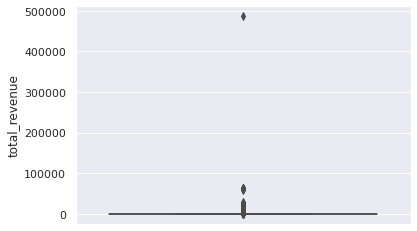

In [19]:
# наглядная визуализация распредления нормированной выручки по группам (1 контрольная группа), заметен явный выброс
sns.set(rc = {'figure.figsize':(6,4)})

sns.boxplot (y = uc1.total_revenue)

plt.show()

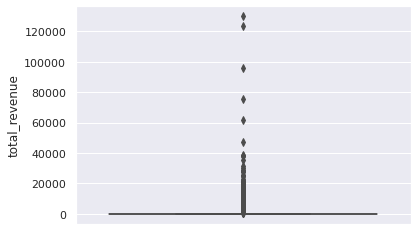

In [20]:
# наглядная визуализация распредления нормированной выручки по группам (тестовая группа для сравнения)
sns.set(rc = {'figure.figsize':(6,4)})

sns.boxplot (y = ut.total_revenue)

plt.show()

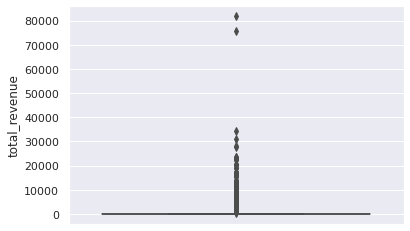

In [21]:
# наглядная визуализация распредления нормированной выручки по группам (контрольная группа 2 для сравнения)
sns.set(rc = {'figure.figsize':(6,4)})

sns.boxplot (y = uc2.total_revenue)

plt.show()

In [22]:
# необходимо более детально проанализировать поведение пользователя из 1-й контрольной группы, приносящего наибольшую выручку
uc1.query("total_revenue == '486330'")

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
1427,892333905,22,175,3608.0,Italy,"1,2,3,4,5,6,7,15",1,19,25,575,1.0,1.0,486330


Проанализируем информацию о платежах пользователей, а потом вернемся к пользователю, приносящему максимальную выручку. Пока можно сделать вывод о том, что пользователь зарегистрировался, купил премиум подписку, и она автоматически продлевается каждый месяц, при этом юзер не заходит в приложение.

Теперь рассмотрим информацию о платежах пользователей.

In [23]:
print (tt.head(), '\n')
print (tt.info(), '\n')
print (tt.isnull().sum(), '\n')
print ('Уникальных UID:', tt.uid.nunique())

         uid                   country            joined_at  \
0  891345942                     Italy  2017-05-11 13:00:00   
1  892054251  United States of America  2017-10-22 00:33:00   
2  892236423  United States of America  2017-10-18 01:09:00   
3  892236423  United States of America  2017-10-18 01:09:00   
4  892168170  United States of America  2017-10-19 17:10:00   

               paid_at  revenue  payment_id        from_page   product_type  
0  2017-11-13 15:04:00    12909         147  trial_vip_popup  trial_premium  
1  2017-10-30 01:37:00    13923         147  trial_vip_popup  trial_premium  
2  2017-10-23 00:15:00     3783          67             menu     other_type  
3  2017-10-27 22:38:00     3783          67             menu     other_type  
4  2017-10-27 19:10:00     9087         147  trial_vip_popup  trial_premium   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273 entries, 0 to 272
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  

In [24]:
print (tc1.head(), '\n')
print (tc1.info(), '\n')
print (tc1.isnull().sum(), '\n')
print ('Уникальных UID:', tc1.uid.nunique())

           uid country            joined_at              paid_at  revenue  \
0  891319275.0  France  2017-05-11 19:57:00  2017-12-11 21:57:00  12727.0   
1  892421826.0  Israel  2017-10-14 12:46:00  2017-10-23 12:54:00  14586.0   
2  891822480.0   Italy  2017-10-26 22:27:00  2017-12-11 20:59:00   1911.0   
3  891367521.0   Italy  2017-05-11 02:37:00  2017-06-11 19:15:00   1456.0   
4  892207959.0  France  2017-10-18 18:30:00  2017-12-11 12:03:00   1261.0   

   payment_id        from_page   product_type  
0       147.0  trial_vip_popup  trial_premium  
1       147.0  trial_vip_popup  trial_premium  
2        19.0             none          coins  
3       127.0         sympathy     other_type  
4        19.0      empty_likes          coins   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1007 entries, 0 to 1006
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   uid           377 non-null    float64
 1   country

In [25]:
print (tc2.head(), '\n')
print (tc2.info(), '\n')
print (tc2.isnull().sum(), '\n')
print ('Уникальных UID:', tc2.uid.nunique())

         uid                   country            joined_at  \
0  891266616                 Argentina  2017-06-11 15:25:00   
1  892186737                     Chile  2017-10-19 06:03:00   
2  891959004  United States of America  2017-10-24 00:12:00   
3  892115478                     Spain  2017-10-20 20:39:00   
4  891592941               Switzerland  2017-10-31 12:40:00   

               paid_at  revenue  payment_id        from_page      product_type  
0  2017-10-11 17:35:00     6305          19       autorefill             coins  
1  2017-04-11 08:53:00     4732         147         promo_09  premium_no_trial  
2  2017-10-31 02:12:00    10153         147  trial_vip_popup     trial_premium  
3  2017-10-26 06:26:00     2366          67      empty_likes        other_type  
4  2017-03-11 16:25:00     6292         147         promo_09  premium_no_trial   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 328 entries, 0 to 327
Data columns (total 8 columns):
 #   Column        Non-Null C

In [26]:
# перевод строковых колонок в тип дататайм
tt[['joined_at', 'paid_at']] = tt[['joined_at', 'paid_at']].apply(pd.to_datetime)
tc1[['joined_at', 'paid_at']] = tc1[['joined_at', 'paid_at']].apply(pd.to_datetime)
tc2[['joined_at', 'paid_at']] = tc2[['joined_at', 'paid_at']].apply(pd.to_datetime)

In [27]:
# удаляем пустые строки из платежных данных 1-ой контрольной выборки
tc1 = tc1.dropna()

In [28]:
# перевод uid и payment_id в целое число в платежных данных 1-ой контрольной выборки
tc1['uid'] = tc1['uid'].astype(int)
tc1['payment_id'] = tc1['payment_id'].astype(int)

In [29]:
# проверка на дубликаты
print('Дубликаты в transactions_test:     ', tt.duplicated().sum())
print('Дубликаты в transactions_control_1:', tc1.duplicated().sum())
print('Дубликаты в transactions_control_2:', tc2.duplicated().sum())

Дубликаты в transactions_test:      7
Дубликаты в transactions_control_1: 21
Дубликаты в transactions_control_2: 5


In [30]:
# дроп дубликатов
tt  = tt.drop_duplicates()
tc1 = tc1.drop_duplicates()
tc2 = tc2.drop_duplicates()

Построим различные визуализации для анализа информации о платежах пользователей:

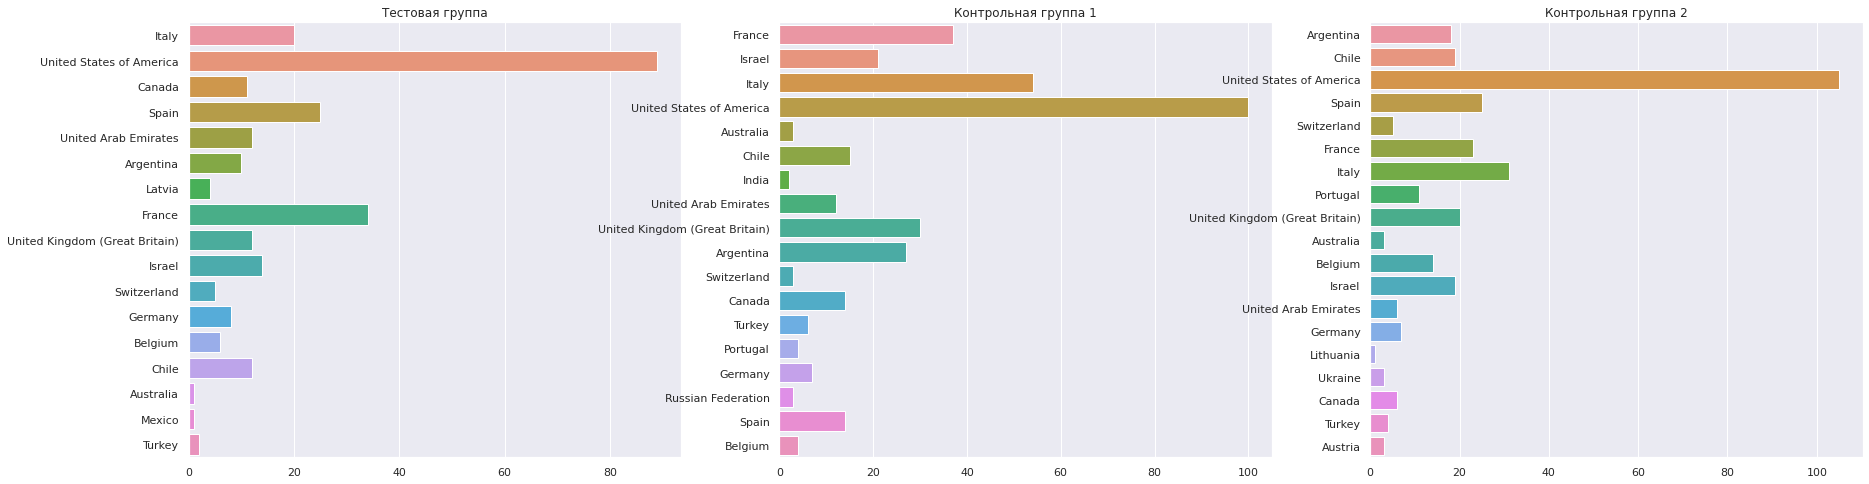

In [31]:
# визуализация платящих юзеров приложения по странам
plt.figure(figsize = (30, 8))

plt.subplot(1, 3, 1)
plt.title('Тестовая группа', fontsize = 12)
sns.countplot(y = tt.country)
plt.xlabel('')
plt.ylabel('')

plt.subplot(1, 3, 2)
plt.title('Контрольная группа 1', fontsize = 12)
sns.countplot(y = tc1.country)
plt.xlabel('')
plt.ylabel('')

plt.subplot(1, 3, 3)
plt.title('Контрольная группа 2', fontsize = 12)
sns.countplot(y = tc2.country)
plt.xlabel('')
plt.ylabel('')

plt.show()

Можно сделать вывод о том, что платную подписку преимущественно оформляют пользователи из США. В 1-й контрольной группе также можно отметить активность пользователей из Италии.

In [32]:
# описательная статистика тестовой группы
tt.describe(datetime_is_numeric = True).round(1)

,uid,joined_at,paid_at,revenue,payment_id
count,266.0,266,266,266.0,266.0
mean,891830170.3,2017-09-05 04:54:23.909774080,2017-09-05 08:19:27.969924864,8767.8,100.0
min,891071157.0,2017-01-11 03:07:00,2017-01-11 04:37:00,533.0,0.0
25%,891499443.0,2017-08-11 03:54:00,2017-07-11 20:57:45,3129.8,19.0
50%,891893487.0,2017-10-18 20:34:00,2017-10-22 14:40:30,6363.5,146.0
75%,892097937.0,2017-10-23 13:08:00,2017-10-29 07:48:00,12597.0,147.0
max,892438635.0,2017-10-31 23:40:00,2017-12-11 22:06:00,113477.0,147.0
std,377585.8,NaN,NaN,11216.2,57.4


In [33]:
# описательная статистика контрольной группы 1
tc1.describe(datetime_is_numeric = True).round(1)

,uid,joined_at,paid_at,revenue,payment_id
count,356.0,356,356,356.0,356.0
mean,892387441.7,2017-08-21 21:52:31.685393152,2017-09-03 23:56:06.067415808,7007.9,94.0
min,891092322.0,2015-01-19 11:49:00,2016-12-14 16:16:00,26.0,0.0
25%,891403026.8,2017-06-11 17:41:45,2017-07-11 11:56:15,2804.8,19.0
50%,891822480.0,2017-10-17 03:36:00,2017-10-17 10:34:30,6292.0,146.0
75%,892166213.2,2017-10-23 12:14:30,2017-10-28 05:51:45,7312.5,147.0
max,960936960.0,2017-10-31 22:17:00,2017-12-11 21:57:00,63037.0,147.0
std,6340717.2,NaN,NaN,7986.0,58.5


In [34]:
# описательная статистика контрольной группы 2
tc2.describe(datetime_is_numeric = True).round(1)

,uid,joined_at,paid_at,revenue,payment_id
count,323.0,323,323,323.0,323.0
mean,891809081.8,2017-09-18 19:07:11.702786560,2017-09-03 21:10:33.250774016,5907.1,96.6
min,891068079.0,2017-01-11 08:36:00,2017-01-11 05:34:00,481.0,0.0
25%,891546181.5,2017-10-11 11:45:00,2017-07-11 11:45:00,2340.0,19.0
50%,891857007.0,2017-10-20 14:49:00,2017-10-21 20:12:00,4719.0,146.0
75%,892128138.0,2017-10-26 01:52:30,2017-10-28 10:42:30,6350.5,147.0
max,892438776.0,2017-10-31 17:43:00,2017-12-11 23:28:00,81796.0,147.0
std,382241.1,NaN,NaN,6615.2,57.0


 Исходя из условий задания и описательной статистики в разрезе транзакций можно сделать вывод о том, что A/B тест для новых пользователей из разных стран продолжался с 11 января 2017 года по 11 декабря 2017 года. Но в 1-ой контрольной группе есть пользователи, зарегистрированные в 2015 году и совершившие оплату до января 2017 года. Необходимо более детально посмотреть, что это за пользователи.

In [35]:
# фильтруем пользователей, которые зарегистрировались до 11 января 2017 года
tc1[tc1.joined_at.dt.strftime('%Y-%m-%d') < '2017-01-11']

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
65,960936960,Russian Federation,2015-01-19 11:49:00,2016-12-14 17:30:00,26.0,0,refund_VP,other_type
101,960936960,Russian Federation,2015-01-19 11:49:00,2016-12-14 17:35:00,637.0,0,refung_AP,other_type
224,960936960,Russian Federation,2015-01-19 11:49:00,2016-12-14 16:16:00,143.0,0,refund_WP,other_type


In [36]:
# также посмотрим на данные этого пользователя
uc1[uc1.uid == 960936960]

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
510,960936960,30,4,99958.0,Russian Federation,"1,2,3,4,7,8,9,10,11,14,15,16,17,18,21,22,23,24...",1,26,62,4262,1.0,1.0,26


Только один пользователь, участвующий в эксперименте был зарегистрирован до 11 января 2017 года, также он совершил 3 транзакции в 2016 году, что противоречит условиям эксперимента и является ошибкой. Поэтому необходимо удалить данные об этом пользователе из датасетов для чистоты эксперимента.

In [37]:
# удаление пользователя с uid 960936960 для чистоты эксперимента
uc1 = uc1.query ('uid != 960936960')
tc1 = tc1.query('uid != 960936960')

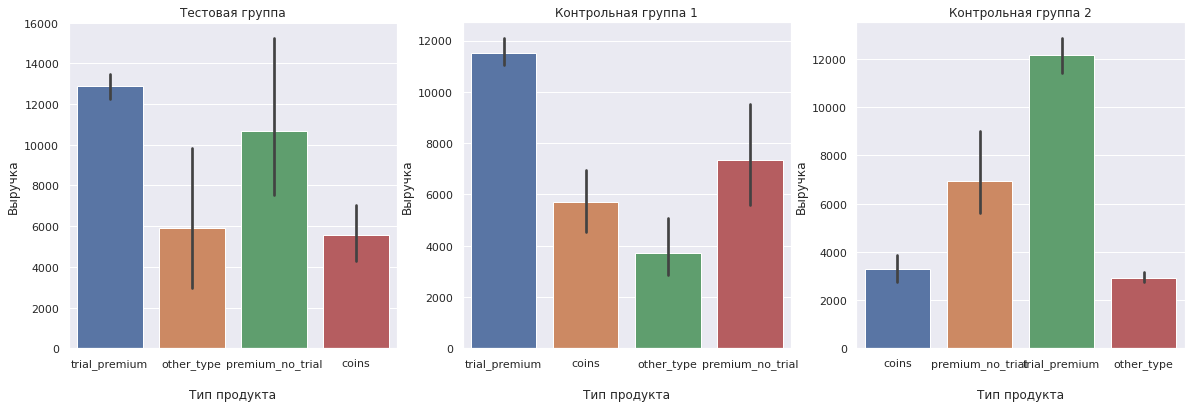

In [38]:
# визуализация выручки в зависимости от типа продукта (тестовая группа)
plt.figure(figsize = (20,6))

plt.subplot(1, 3, 1)
plt.title('Тестовая группа', fontsize = 12)
sns.barplot(data = tt,\
               x = tt['product_type'], \
               y = tt['revenue'] )

plt.xlabel('\nТип продукта')
plt.ylabel('Выручка')

plt.subplot(1, 3, 2)
plt.title('Контрольная группа 1', fontsize = 12)
sns.barplot(data = tc1,\
               x = tc1['product_type'], \
               y = tc1['revenue'] )

plt.xlabel('\nТип продукта')
plt.ylabel('Выручка')

plt.subplot(1, 3, 3)
plt.title('Контрольная группа 2', fontsize = 12)
sns.barplot(data = tc2,\
               x = tc2['product_type'], \
               y = tc2['revenue'] )

plt.xlabel('\nТип продукта')
plt.ylabel('Выручка')

plt.show()

Как видно из графиков, во всех группах наибольшую выручку приносит пробная премиум подписка. Часть пользователей остается на премиум подписке после пробного периода, т.е. данные пользователи лояльны к приложению.

Вернемся к пользователю из 1-ой контрольной группы с uid 892333905 и проверим его транзакции.

In [39]:
tc1.query('uid == 892333905').sort_values('paid_at')

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
49,892333905,Italy,2017-10-16 01:38:00,2017-10-16 01:42:00,3783.0,67,menu,other_type
13,892333905,Italy,2017-10-16 01:38:00,2017-10-16 01:44:00,3783.0,67,menu,other_type
28,892333905,Italy,2017-10-16 01:38:00,2017-10-16 01:57:00,3783.0,67,empty_admins,other_type
43,892333905,Italy,2017-10-16 01:38:00,2017-10-16 01:58:00,3783.0,67,empty_admins,other_type
6,892333905,Italy,2017-10-16 01:38:00,2017-10-16 02:08:00,12610.0,19,gifts,coins
137,892333905,Italy,2017-10-16 01:38:00,2017-10-16 02:08:00,31525.0,19,gifts,coins
289,892333905,Italy,2017-10-16 01:38:00,2017-10-16 02:08:00,3783.0,67,gifts,other_type
149,892333905,Italy,2017-10-16 01:38:00,2017-10-16 02:08:00,1261.0,19,gifts,coins
297,892333905,Italy,2017-10-16 01:38:00,2017-10-16 02:26:00,31525.0,19,menu,coins
316,892333905,Italy,2017-10-16 01:38:00,2017-10-16 02:52:00,31525.0,19,menu,coins


Данный пользователь совершал транзакции в первые два дня после регистрации (покупал монеты, подписку и что-то другое (other_type), т.е. предположение о том, что пользователь приобрел и не отменил подписку отпадает. Некоторые транзакции с одинаковым идентификатором и суммой платежа, совершены с разницей в пару минут. Возможно, произошла какая-то системная ошибка. Необходимо удалить данного пользователя из группы, дабы не искажать расчеты и не создавать выброс.

In [40]:
# удаление пользователя, создающего существенный выброс
uc1 = uc1.query ('uid != 892333905')
tc1 = tc1.query('uid != 892333905')

Необходимо также сравнить данные по выручкам из датасетов с информацией о пользователях и информацией о совершенных транзакциях, для этого напишем функции:

In [41]:
tables = {'test': [ut, tt],
          'control_1': [uc1, tc1],
          'control_2': [uc2, tc2]}
    
def get_users(group) :
    return tables[group][0]

def get_transactions(group) :
    return tables[group][1]

def update_tables() :
    global tables
    tables = {'test': [ut, tt],
              'control_1': [uc1, tc1],
              'control_2': [uc2, tc2]}

In [42]:
groups = ['test', 'control_1', 'control_2']

for group_name in groups :
    users_table                       = get_users(group_name)
    transactions_table                = get_transactions(group_name)
    
    users_table_total_revenue         = users_table.total_revenue.sum()
    transactions_table_total_revenue  = transactions_table.revenue.sum()
    
    print('Выручка в группе "{}" составила:'.format(group_name))
    print(users_table_total_revenue, 'согласно таблице с данными пользователей')
    print(transactions_table_total_revenue, 'согласно таблице с данными транзакций')
    print('Ошибка равна',
          round(100 * \
                    abs(transactions_table_total_revenue \
                        - users_table_total_revenue) \
                    / transactions_table_total_revenue,\
                1),
          '% или',
          abs(transactions_table_total_revenue - users_table_total_revenue))
    print('  ')

Выручка в группе "test" составила:
2300818 согласно таблице с данными пользователей
2332226 согласно таблице с данными транзакций
Ошибка равна 1.3 % или 31408
  
Выручка в группе "control_1" составила:
2094911 согласно таблице с данными пользователей
2090894.0 согласно таблице с данными транзакций
Ошибка равна 0.2 % или 4017.0
  
Выручка в группе "control_2" составила:
1920438 согласно таблице с данными пользователей
1907997 согласно таблице с данными транзакций
Ошибка равна 0.7 % или 12441
  


Теперь необходимо найти данные отклонения в выручке во всех таблицах, путем выверки в разрезе пользователей:

In [43]:
def revenue_dev(group_name) :

    revenue_users = \
        get_users(group_name) \
        [['uid', 'total_revenue']]

    revenue_transactions = \
        get_transactions(group_name) \
        .groupby('uid', as_index = False) \
        .agg({'revenue': 'sum'})

    revenue_d = revenue_users.merge(revenue_transactions, on = 'uid', how = 'outer')
    revenue_d = revenue_d.fillna(value = {'revenue': 0})
    revenue_d['revenue'] = revenue_d['revenue']

    dif = \
        revenue_d[revenue_d['revenue'] \
                        != revenue_d['total_revenue']]

    return dif

In [44]:
# разница в выручке в разрезе пользователей тестовой группы
dif_test = revenue_dev('test')
dif_test['dif'] = dif_test.total_revenue - dif_test.revenue
print(dif_test)
print(dif_test.dif.sum())

            uid  total_revenue  revenue      dif
406   892236423          95823  86996.0   8827.0
761   891508155          10101   9165.0    936.0
1736  892050108          16380  15119.0   1261.0
1900  892339626          17758  17004.0    754.0
2070  892275462          14885  58968.0 -44083.0
2630  892202526           2691   1794.0    897.0
-31408.0


In [45]:
# разница в выручке в разрезе пользователей контрольной группы 1
dif_control_1 = revenue_dev('control_1')
dif_control_1['dif'] = dif_control_1.total_revenue - dif_control_1.revenue
print(dif_control_1)
print(dif_control_1.dif.sum())

            uid  total_revenue  revenue      dif
259   891367521          20462  16081.0   4381.0
1326  891721851          18174  17277.0    897.0
1923  891452706          18902  12597.0   6305.0
2459  891252072           8814   7553.0   1261.0
2713  892207959          18902  16380.0   2522.0
2855  891320916          13858  10075.0   3783.0
2941  891365490          10075   8814.0   1261.0
3214  891739737          21424  20163.0   1261.0
3368  892355163              0  30264.0 -30264.0
3866  892102893          25220  12610.0  12610.0
4017.0


In [46]:
# разница в выручке в разрезе пользователей контрольной группы 2
dif_control_2 = revenue_dev('control_2')
dif_control_2['dif'] = dif_control_2.total_revenue - dif_control_2.revenue
print(dif_control_2)
print(dif_control_2.dif.sum())

            uid  total_revenue  revenue     dif
271   892064328          18902  12597.0  6305.0
643   892009254           7072   4719.0  2353.0
652   892062660           2522   1261.0  1261.0
1544  891862596          10075   8814.0  1261.0
2217  892045743          10075   8814.0  1261.0
12441.0


Все отклонения сходятся с результатами расчета предыдущего шага.
\
Необходимо удалить данных пользователей для чистоты эксперимента.

In [47]:
# удаление пользователей с разницей в выручке
ut = ut[~ut['uid'].isin(dif_test['uid'])]
tt = tt[~tt['uid'].isin(dif_test['uid'])]

uc1 = uc1[~uc1['uid'].isin(dif_control_1['uid'])]
tc1 = tc1[~tc1['uid'].isin(dif_control_1['uid'])]

uc2 = uc2[~uc2['uid'].isin(dif_control_2['uid'])]
tc2 = tc2[~tc2['uid'].isin(dif_control_2['uid'])]

Проведем проверку сплитования для того, чтобы убедиться в отсуствии взаимозависимых связок в разрезе пользователей (т.е. пользователи из одной выборки не должны встречаться в других)

In [48]:
split_test = ut['uid']
split_control_1 = uc1['uid']
split_control_2 = uc2['uid']

print(split_test.shape[0] == split_test.nunique())
print(split_control_1.shape[0] == split_control_1.nunique())
print(split_control_2.shape[0] == split_control_2.nunique())

True
True
True


In [49]:
split_all = [split_test.to_frame(), split_control_1.to_frame(), split_control_2.to_frame()]
N = len(split_all)

for i in range(N):
    print(split_all[i].merge(split_all[(i + 1) % N], on = 'uid', how = 'inner').shape[0] == 0)

True
True
True


Все явные выбросы были удалены и теперь можно говорить о чистоте проведения эксперимента. В эксперименте участвуют новые пользователи, которые зарегистрировались в приложении с 11 января 2017 года по 31 октября 2017 года и проводили транзакции с 11 января 2017 года по 11 декабря 2017 года. Группы пользователей по социальной идентичности распределены равномерно, что говорит о репрезентативности.Проверка сплитования показала, что в исследуемых группах соблюдаются пропорции в разрезе пользователей, т.е. они не повторяются в разных группах.

Необходимо объединить все данные в таблицу для упрощения дальнейшего анализа

In [50]:
def save_big_table(group_name) :
    big_table = \
        get_transactions(group_name) \
        .merge(get_users(group_name).drop(['country'], axis = 1),
               on = 'uid',
               how = 'outer')
    
    return big_table

In [51]:
def save_big_tables() :
    big_tables = {}

    for group_name in groups :
        big_tables = {**big_tables, **{group_name : save_big_table(group_name)}}
    return big_tables

In [52]:
big_tables = save_big_tables()

In [53]:
def big_tables_upd() :
    global big_tables
    big_tables = save_big_tables()

Дадим ответ на первый поставленный в задаче вопрос - Был ли эксперимент успешен в целом

Для ответа на данный вопрос необходимо разработать систему метрик по которым будет производиться оценка эксперимента:
- Конверсия из пользователя в покупателя (CR)
- Конверсия из пользователя в покупателя премиум подписки (CRp)
- Средний доход на пользователя (ARPU)
- Средний доход на платящего пользователя (ARPPU)

In [54]:
# Построим таблицу с метриками
df = []

for group_name in groups :
    users_table = get_users(group_name)
    transactions_table = get_transactions(group_name)
    
    users = users_table['uid'].nunique()
    buyers = users_table.query("total_revenue > 0")["uid"].nunique()
    buyers_p = transactions_table.query("revenue > 0 & product_type == 'premium_no_trial'")["uid"].nunique()
    orders = transactions_table['payment_id'].count()
    revenue = transactions_table.revenue.sum()
    CR = round(buyers / users, 4)
    CRp = round(buyers_p / users, 4)
    APC = round(orders / buyers, 4)
    AvPrice = round(revenue / orders, 4)
    ARPPU = round(revenue / buyers, 2)
    ARPU = round(revenue / users, 2)
    
    df.append(pd.DataFrame(index = [group_name],
                                  data = {'users' : users,
                                          'CR' : CR,
                                          'buyers' : buyers,
                                          'CRp' : CRp,
                                          'buyers_p' : buyers_p,
                                          'APC' : APC,
                                          'orders' : orders,
                                          'AvPrice' : AvPrice,                                          
                                          'revenue' : revenue,
                                          'ARPU' : ARPU,
                                          'ARPPU' : ARPPU}))

metrics_table = pd.concat(df)
metrics_table

,users,CR,buyers,CRp,buyers_p,APC,orders,AvPrice,revenue,ARPU,ARPPU
test,4308,0.0339,146,0.0156,67,1.8219,266,8767.7669,2332226.0,541.37,15974.15
control_1,4338,0.0438,190,0.0226,98,1.7579,334,6260.1617,2090894.0,481.99,11004.71
control_2,4264,0.0439,187,0.0239,102,1.7273,323,5907.1115,1907997.0,447.47,10203.19


- Количество пользователей в трех группах находится примерно на одинаковом уровне.
- Количество покупателей в тестовой группе уменьшилось примерно на 30%.
- Конверсия в покупку (CR) в тестовой группе на 1 п.п. меньше, чем в контрольных группах. Пользователи начали меньше интересоваться покупкой платных опций после изменения стоимости премиум-подписки при покупке через две новые платежные системы (возможно было повышение тарифов).
- Конверсия в покупку премиум подписки (CRp) уменьшилась на 0,8 п.п. в рамках проведения эксперимента. Данная метрика напрямую зависит от цены подписки и может свидетельствовать об успешности проведения эксперимента. Но необходимо также посмотреть и остальные метрики. Таже отметим, что уменьшилось количество покупателей премиум подписки на 49%.
- Число заказов также уменьшилось примерно в 1,2 раза. Но среднее число покупок на одного клиента (APC) увеличилось на 3,5%. Следовательно, наблюдается положительная динамика и по среднему чеку (AvPrice), так средний чек контрольных групп вырос на 2500 ед.
- Выручка приложения также увеличилась примерно на 15%.
- Средний доход на пользователя (ARPU) и средний доход на платящего пользователя (ARPPU) также существенно выросли, примерно в 1,5 раза.

Перечисленные метрики могут свидетельствовать об успешном проведении эксперимента и о возможности запуска в продакшн. Но необходимо также провести анализ статистической значимости.

Также перед переходом к АА и АБ тестирвоаниям можно оценить качество сплитования в разрезе пола, возраста, страны использования, чтобы заранее предупредить сбои при разделении пользователей на группы. Данные ошибки могут повлиять на объективность эксперимента.
\
\
Так, для проверки сплитования количественных переменных логично использовать ANOVA (возраст), а для качественных (пол, страна) - хи-квадрат.

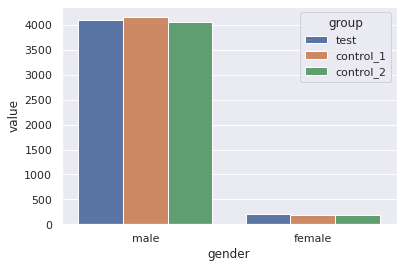

In [55]:
# оценка качества сплитования групп по полу
genders = []

for group_name in groups :
    users_table = get_users(group_name)
    transactions_table = get_transactions(group_name)

    male = users_table.query("gender == 1")["uid"].nunique()
    female = users_table.query("gender == 0")["uid"].nunique()


    genders.append(pd.DataFrame(index = [group_name],
                              data = {'male' : male,
                                      'female' : female}))

gender_table = pd.concat(genders)
group = ['test', 'control_1', 'control_2']

gender_table["group"] = group
melted = gender_table.melt("group", value_name = "value", var_name = "gender")

sns.barplot(data = melted, x = "gender", y = "value", hue = "group")

plt.show()

Следует отметить, что в каждой из групп примерно одинаковое число мужчин и женщин.
\
\
Проведем проверку статистической значимости:
- H0 - различия по гендерному признаку в тестовой и контрольных группах статистически не значимы
- H1 - различия по гендерному признаку в тестовой и контрольных группах статистически значимы

Критерий значимости: p > 0.05 - нет оснований отвергнуть нулевую гипотезу о том, что признаки статистически не значимы

In [56]:
# оставим нужные столбцы для корректного проведения теста
gender_p = gender_table[['male','female']]

In [57]:
stat, p, dof, expected = chi2_contingency(gender_p)
p

0.5105538528684621

p = 0.51, т.е. p > 0.05, следовательно, мы не можем отвергнуть H0. А это значит, что различия по гендерному признаку в тестовой и контрольных группах статистически не значимы.

In [58]:
# объединение таблицы для более удобной и быстрой сортировки по стране и группе
ut['group'] = 'test'
uc1['group'] = 'control_1'
uc2['group'] = 'control_2'
users_all = pd.concat([ut, uc1, uc2])

tt['group'] = 'test'
tc1['group'] = 'control_1'
tc2['group'] = 'control_2'
transactions_all = pd.concat([tt, tc1, tc2])

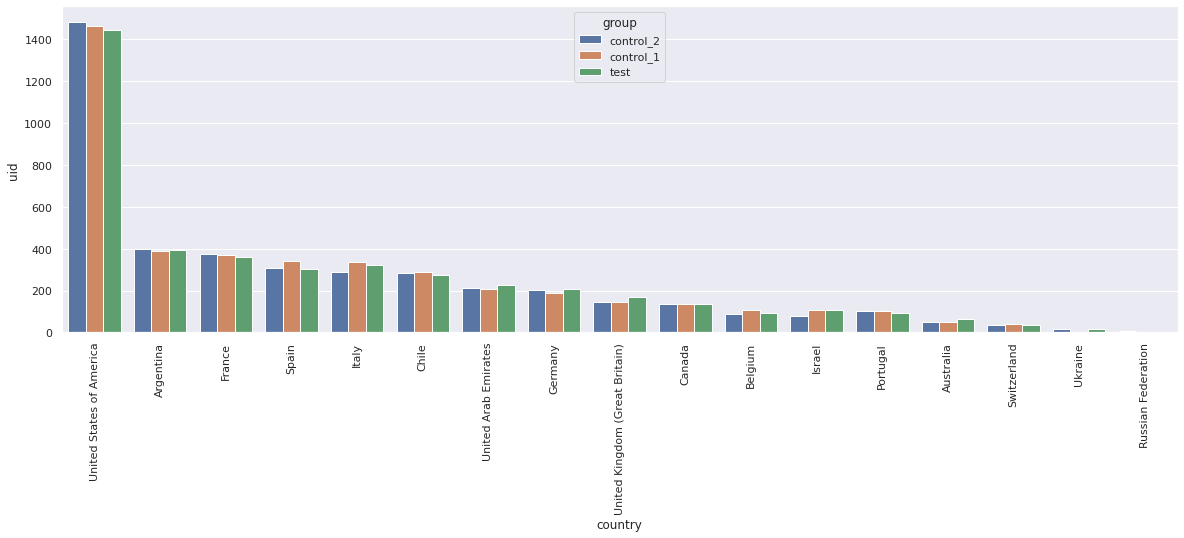

In [59]:
# оценка качества сплитования групп по странам
country = users_all.groupby(['country', 'group'], as_index = False).agg ({'uid':'count'}).sort_values(by = 'uid', ascending=False).head(48)
plt.figure(figsize = (20, 6))
sns.barplot(data = country, x = "country", y = "uid", hue = "group")
plt.xticks(rotation = 90)
plt.show()

Распределение пользователей по странам в каждой группе примерно на одном уровне.
\
\
Проведем проверку статистической значимости:
- H0 - различия по географическому признаку в тестовой и контрольных группах статистически не значимы
- H1 - различия по географическому признаку в тестовой и контрольных группах статистически значимы

Критерий значимости: p > 0.05 - нет оснований отвергнуть нулевую гипотезу о том, что признаки статистически не значимы

In [60]:
# оставляем нужные данные, определяем количество пользователей по странам в каждой из групп
country_p = pd.crosstab(users_all.country, users_all.group).sort_values("test", ascending = False)
country_p

group,control_1,control_2,test
country,,,
United States of America,1466,1484,1447
Argentina,388,397,396
France,369,376,358
Italy,335,291,323
Spain,342,310,301
...,...,...,...
"Moldova, Republic of",1,0,0
New Zealand,0,1,0
Nicaragua,0,1,0


In [61]:
stat, p, dof, expected = chi2_contingency(country_p)
p

0.6881818752154022

p = 0.69, т.е. p > 0.05, следовательно, мы не можем отвергнуть H0. А это значит, что различия по географическому признаку в тестовой и контрольных группах статистически не значимы.

Ранее при анализе данных я сделал вывод о том, что особых различий по возрастному признаку в тестовых и контрольных групп нет. Средний возраст во всех трех группах находится на уровне 32 лет. Но также необходимо провести проверку и определить уровень статистической значимости различий в возрасте между тремя группами, чтобы убедиться в сделанном ранее предположении.
\
\
Проведем проверку статистической значимости:
- H0 - различия по возрасту в тестовой и контрольных группах статистически не значимы
- H1 - различия по возрасту в тестовой и контрольных группах статистически значимы

Критерий значимости: p > 0.05 - нет оснований отвергнуть нулевую гипотезу о том, что признаки статистически не значимы

In [62]:
F, p = f_oneway(users_all.query('group == "test"').age,
                users_all.query('group == "control_1"').age,
                users_all.query('group == "control_2"').age)
print ('p =', p)

p = 0.6046913765764144


 p = 0.6, т.е. p > 0.05 - нельзя отвергнуть нулевую гипотезу, у нас нет статистически значимой разницы, то есть пользователи в каждой из групп действительно примерно одинакового возраста. Средний возраст в группе равен 32 годам.  

Более детальная проверка сплитования показала, что пользователи в группах распределены равномерно, как следствие, эксперимент должен дать объективный результат.

## Проведение АА тестирования

Перед проведением АБ теста проведем проверку метрик в контрольных группах для того, чтобы убедиться в корректности работы системы.
\
Проверять будем, используя параметрический тест, который показывает, насколько значительны различия между группами (ttest).
\
Проверка будет проходить на основе сравнения выбранных ранее метрик: CR, CRp, ARPU, ARPPU.
\
Критерий значимости: FRP < 0.05 - система сплитования работает корректно, переходим к АБ тесту.

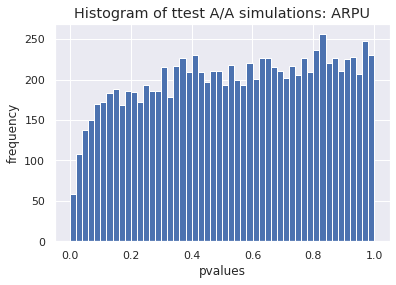

0.0236

In [63]:
# проверка т-тестом ARPU (средний доход на пользователя)
simulations = 10000
n_s = 1000
res = []

for i in range(simulations):
    s1 = users_all[users_all.group == 'control_1']['total_revenue'].sample(n_s, replace = False).values
    s2 = users_all[users_all.group == 'control_2']['total_revenue'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1])

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations: ARPU")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) < 0.05) / simulations

FRP = 0.02, т.е. FRP < 0.05, следовательно, система сплитования работает корректно. Статистически значимых различий по среднему доходу на пользователя в контрольных группах не наблюдается. Можно переходить к АБ-тесту.

In [64]:
# добавление колонки, где будет отражена информация была ли совершена покупка пользователем (для анализа метрики CR)
users_all['purchase'] = users_all.total_revenue > 0

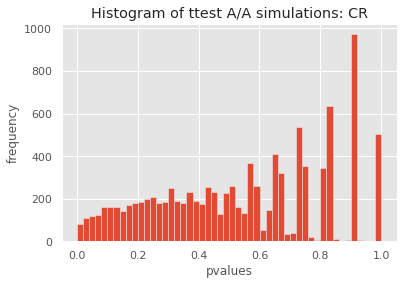

0.0244

In [65]:
# проверка т-тестом CR (конверсия в покупку)
simulations = 10000
n_s = 1000
res = []

for i in range(simulations):
    s1 = users_all[users_all.group == 'control_1']['purchase'].sample(n_s, replace = False).values
    s2 = users_all[users_all.group == 'control_2']['purchase'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1])

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations: CR")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) < 0.05) / simulations

FRP = 0.03, т.е. FRP < 0.05, следовательно, система сплитования работает корректно. Статистически значимых различий по показателю конверсии в покупку не наблюдается. Можно переходить к АБ-тесту.

In [66]:
# создание столбца с информацией о пользователях, которые покупали премиум-подписку
users_all['premium'] = users_all.uid.isin(transactions_all.query('product_type == "premium_no_trial"').uid.unique())

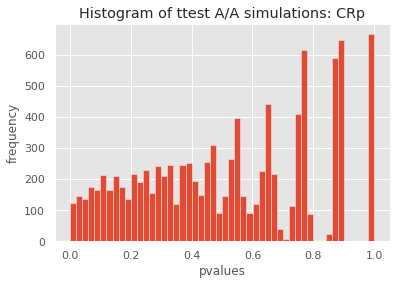

0.0335

In [67]:
# проверка т-тестом CRp (конверсия в платную покупку)
simulations = 10000
n_s = 1000
res = []

for i in range(simulations):
    s1 = users_all[users_all.group == 'control_1']['premium'].sample(n_s, replace = False).values
    s2 = users_all[users_all.group == 'control_2']['premium'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1])

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations: CRp")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) < 0.05) / simulations

FRP = 0.03, т.е. FRP < 0.05, следовательно, система сплитования работает корректно. Статистически значимых различий по показателям конверсии в премиум подписку в контрольных группах не наблюдается. Можно переходить к АБ-тесту.

In [68]:
# датафрейм для проверки системы сплитования по метрике ARPPU
users_arppu = users_all.query('total_revenue > 0')

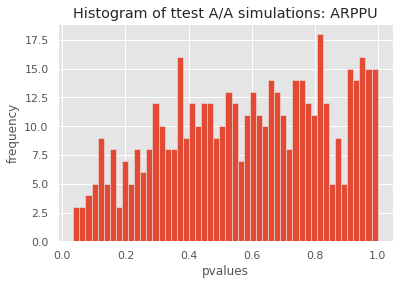

0.006

In [69]:
# проверка т-тестом ARPPU (средний доход на платящего пользователя)
simulations = 500
n_s = 100
res = []

for i in range(simulations):
    s1 = users_arppu[users_arppu.group == 'control_1']['total_revenue'].sample(n_s, replace = False).values
    s2 = users_arppu[users_arppu.group == 'control_2']['total_revenue'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1])

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations: ARPPU")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) < 0.05) / simulations

 FRP = 0.002, т.е. FRP < 0.05, следовательно, система сплитования работает корректно. Статистически значимых различий по среднему доходу на платящего пользователя в контрольных группах не наблюдается. Можно переходить к АБ-тесту.

Подводя итог проверки системы сплитования, можно сделать вывод о том, что при проведении АБ тестов система будет работать корректно и не даст сбой, искажения в результатах исследуемых метрик не произойдет.

## Проведение АБ тестирования

Бутстрап-анализ метрик

In [70]:
# Функция, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1 - samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
    
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci, ymin = 0, ymax = 50, linestyle = '--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

Средний доход на пользователя (ARPU)
\
\
Проверка гипотез:

- Н0 - изменение цены подписки в веденных платежных системах не влияет на ARPU (средний доход на пользователя)
- Н1 - изменение цены подписки в веденных платежных системах влияет на ARPU (средний доход на пользователя)  

Критерий значимости: p > 0.05 - не можем отвергнуть H0, значимых статистических различий не выявлено 


Перед началом эксперимента, проверим группы на гомоскедастичность (одинаковость дисперсий)  

Критерий значимости equal_var = True, т.е. группы гомоскедастичны.

In [71]:
pg.homoscedasticity(data = users_all, dv = 'total_revenue', group = 'group')

,W,pval,equal_var
levene,0.384368,0.680889,True


Тест на гомоскедастичность показал, что нет оснований считать дисперсии в группах статистически различными. 
\
\
Проверка на нормальность распределения методом Шапиро-Уилка
\
\
Проверка гипотез:

- Н0 - ARPU распределено нормально
- Н1 - ARPU распределено не нормально

Критерий значимости: p > 0.05 - не можем отвергнуть H0, распределение является нормальным

In [72]:
stat, p = shapiro(users_all.query('group == "test"').total_revenue)
print('test: stat = %.4f, p = %.4f' % (stat, round(p,7)))
stat, p = shapiro(users_all.query('group == "control_1"').total_revenue)
print('control_1: stat = %.4f, p = %.4f' % (stat, round(p,7)))
stat, p = shapiro(users_all.query('group == "control_2"').total_revenue)
print('control_2: stat = %.4f, p = %.4f' % (stat, round(p,7)))
stat, p = shapiro(users_all.query('group != "test"').total_revenue)
print('control_1_2: stat = %.4f, p = %.4f' % (stat, round(p,7)))

test: stat = 0.0983, p = 0.0000
control_1: stat = 0.1357, p = 0.0000
control_2: stat = 0.1412, p = 0.0000
control_1_2: stat = 0.1385, p = 0.0000


Распределение по показателю ARPU в группах не является нормальным. Следовательно, при дальнейшем анализе можно использовать метод бутстрап. 
\
Проверка гипотез методом ANOVA:

- Н0 - изменение цены подписки в веденных платежных системах не влияет на ARPU (средний доход на пользователя)
- Н1 - изменение цены подписки в веденных платежных системах влияет на ARPU (средний доход на пользователя) 

Критерий значимости: p > 0.05 - не можем отвергнуть H0, значимых статистических различий не выявлено

In [73]:
F, p = f_oneway(users_all.query('group == "test"').total_revenue,
                users_all.query('group == "control_1"').total_revenue,
                users_all.query('group == "control_2"').total_revenue)
print ('p =', p)

p = 0.6808888933638777


p > 0.05 - нельзя отвергнуть нулевую гипотезу, у нас нет статистически значимой разницы, то есть ARPU значимо не отличается во всех группах. 
\
\
Проверка гипотез методом бутстрап-анализа:
\
\
Н0 - изменение цены подписки в веденных платежных системах не влияет на ARPU (средний доход на пользователя)
\
Н1 - изменение цены подписки в веденных платежных системах влияет на ARPU (средний доход на пользователя)  
\
Критерий значимости: p > 0.05 - не можем отвергнуть H0, значимых статистических различий не выявлено

In [74]:
# Создадим датасеты со значениями ARPU в трех группах
ARPU_test = users_all.query('group == "test"').total_revenue
ARPU_1 = users_all.query('group == "control_1"').total_revenue
ARPU_2 = users_all.query('group == "control_2"').total_revenue

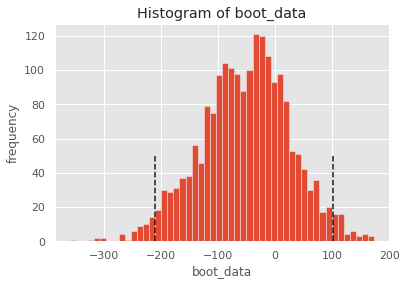

p_value: 0.50839
ДИ:             0
0.025 -209.75
0.975  100.71


In [75]:
# Визуализируем распределение разниц средних бутстрап-выборок в тестовой и первой контрольной группе
ARPU_test_c1 = get_bootstrap(ARPU_1, ARPU_test, boot_it = 2000)

print(f'p_value: {ARPU_test_c1["p_value"].round(5)}')
print(f'ДИ: {ARPU_test_c1["ci"].round(2)}')

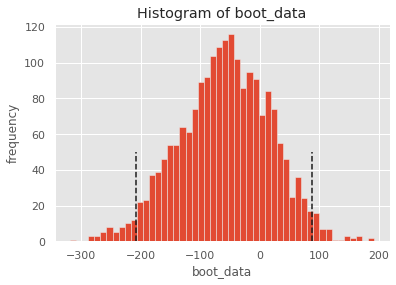

p_value: 0.44429
ДИ:             0
0.025 -208.92
0.975   86.83


In [76]:
# Визуализируем распределение разниц средних бутстрап-выборок в тестовой и второй контрольной группе
ARPU_test_c2 = get_bootstrap(ARPU_2, ARPU_test, boot_it = 2000)

print(f'p_value: {ARPU_test_c2["p_value"].round(5)}')
print(f'ДИ: {ARPU_test_c2["ci"].round(2)}')

Также проведем тест в разрезе контроль1 + контроль2/ тест:

In [77]:
# Создадим датасет со значениями ARPU в объединенной контрольной группе
ARPU_1_2 = users_all.query('group != "test"').total_revenue

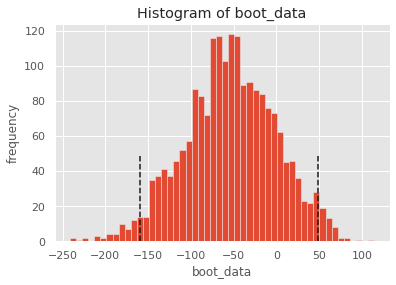

p_value: 0.31115
ДИ:             0
0.025 -159.19
0.975   49.19


In [78]:
# Визуализируем распределение разниц средних бутстрап-выборок в тестовой и объединенной контрольной группе
ARPU_test_c1_2 = get_bootstrap(ARPU_1_2, ARPU_test, boot_it = 2000)

print(f'p_value: {ARPU_test_c1_2["p_value"].round(5)}')
print(f'ДИ: {ARPU_test_c1_2["ci"].round(2)}')

 После проведения бутстрап-анализа можно сделать вывод о том, что оценка доверительных интервалов разницы средних говорит об отсутствии значимых различий показателя ARPU тестовой и контрольных групп (p > 0.05 во всех трех случаях, следовательно, H0 отклонить не можем).

 После проведения ряда тестов не было выявлено существенных различий в ARPU тестовой и контрольных групп, а следовательно, нельзя отклонять нулевую гипотезу, т.е. изменение цены подписки в веденных платежных системах существенно не влияет на ARPU (средний доход на пользователя). Нельзя делать вывод о том, что эксперимент прошел успешно.

### Средний доход на платящего пользователя (ARPPU)

Проверка гипотез:
- Н0 - изменение цены подписки в веденных платежных системах не влияет на ARPPU
- Н1 - изменение цены подписки в веденных платежных системах влияет на ARPUU


Перед началом эксперимента, проверим группы на гомоскедастичность (одинаковость дисперсий)  

Критерий значимости equal_var = True, т.е. группы гомоскедастичны.

In [79]:
pg.homoscedasticity(data = users_all.query('total_revenue > 0'), dv = 'total_revenue', group = 'group')

,W,pval,equal_var
levene,2.740142,0.065531,True


Тест на гомоскедастичность показал, что нет оснований считать дисперсии в группах статистически различными.

Проверка на нормальность распределения методом Шапиро-Уилка
\
\
Проверка гипотез:
- Н0 - ARPPU распределено нормально
- Н1 - ARPPU распределено не нормально  

Критерий значимости: p > 0.05 - не можем отвергнуть H0, распределение является нормальным

In [80]:
stat, p = shapiro(users_all.query('group == "test" and total_revenue > 0').total_revenue)
print('test: stat = %.4f, p = %.4f' % (stat, round(p,7)))
stat, p = shapiro(users_all.query('group == "control_1" and total_revenue > 0').total_revenue)
print('control_1: stat = %.4f, p = %.4f' % (stat, round(p,7)))
stat, p = shapiro(users_all.query('group == "control_2" and total_revenue > 0').total_revenue)
print('control_2: stat = %.4f, p = %.4f' % (stat, round(p,7)))
stat, p = shapiro(users_all.query('group != "test" and total_revenue > 0').total_revenue)
print('control_1_2: stat = %.4f, p = %.4f' % (stat, round(p,7)))

test: stat = 0.5485, p = 0.0000
control_1: stat = 0.6058, p = 0.0000
control_2: stat = 0.6225, p = 0.0000
control_1_2: stat = 0.6195, p = 0.0000


Распределение по показателю ARPPU в группах не является нормальным. Следовательно, при дальнейшем анализе можно использовать метод бутстрап.

 Проверка гипотез методом ANOVA:
- Н0 - изменение цены подписки в веденных платежных системах не влияет на ARPPU (средний доход на платящего пользователя)
- Н1 - изменение цены подписки в веденных платежных системах влияет на ARPPU (средний доход на платящего пользователя)  

Критерий значимости: p > 0.05 - не можем отвергнуть H0, значимых статистических различий не выявлено

In [81]:
F, p = f_oneway(users_all.query('total_revenue > 0 and group == "test"').total_revenue,
                users_all.query('total_revenue > 0 and group == "control_1"').total_revenue,
                users_all.query('total_revenue > 0 and group == "control_2"').total_revenue)
print ('p =', p)

p = 0.0004256432271225576


Так как p < 0.05, то мы отвергаем нулевую гипотезу и делаем вывод, что ARPPU во всех группах статистически значимо отличается.Учитывая неоднозначность результатов необходимо воспользоваться бутстрап анализом.

 Проверка гипотез методом бутстрап-анализа:
 - Н0 - изменение цены подписки в веденных платежных системах не влияет на ARPPU (средний доход на платящего пользователя)
 - Н1 - изменение цены подписки в веденных платежных системах влияет на ARPPU (средний доход на платящего пользователя)  

Критерий значимости: p > 0.05 - не можем отвергнуть H0, значимых статистических различий не выявлено

In [82]:
# Создадим датасеты со значениями ARPPU в четырех группах (одна из которых объединенная контрольная)
ARPPU_test = users_all.query('total_revenue > 0 and group == "test"').total_revenue
ARPPU_1 = users_all.query('total_revenue > 0 and group == "control_1"').total_revenue
ARPPU_2 = users_all.query('total_revenue > 0 and group == "control_2"').total_revenue
ARPPU_1_2 = users_all.query('total_revenue > 0 and group != "test"').total_revenue

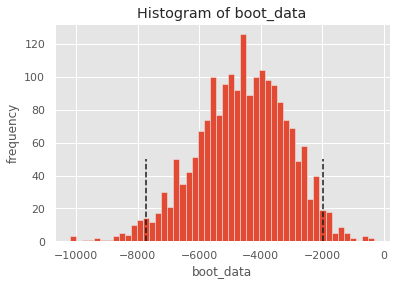

p_value: 0.00186
ДИ:              0
0.025 -7729.59
0.975 -1970.42


In [83]:
# Визуализируем распределение разниц средних бутстрап-выборок в тестовой и первой контрольной группе
ARPPU_test_c1 = get_bootstrap(ARPPU_1, ARPPU_test, boot_it = 2000)

print(f'p_value: {ARPPU_test_c1["p_value"].round(5)}')
print(f'ДИ: {ARPPU_test_c1["ci"].round(2)}')

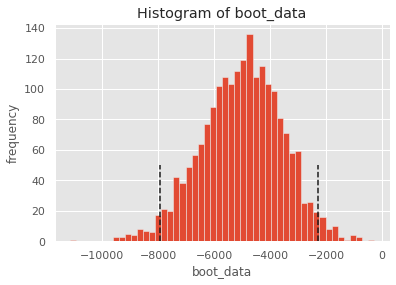

p_value: 0.00054
ДИ:              0
0.025 -7930.32
0.975 -2275.29


In [84]:
# Визуализируем распределение разниц средних бутстрап-выборок в тестовой и второй контрольной группе
ARPPU_test_c2 = get_bootstrap(ARPPU_2, ARPPU_test, boot_it = 2000)

print(f'p_value: {ARPPU_test_c2["p_value"].round(5)}')
print(f'ДИ: {ARPPU_test_c2["ci"].round(2)}')

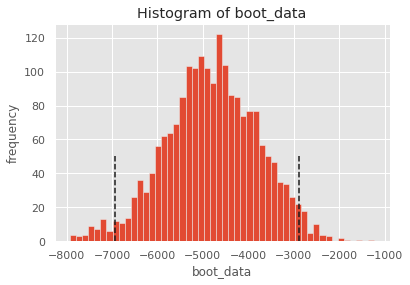

p_value: 0.0
ДИ:              0
0.025 -6940.90
0.975 -2883.06


In [85]:
# Визуализируем распределение разниц средних бутстрап-выборок в тестовой и объединенной контрольной группе
ARPPU_test_c1_2 = get_bootstrap(ARPPU_1_2, ARPPU_test, boot_it = 2000)

print(f'p_value: {ARPPU_test_c1_2["p_value"].round(5)}')
print(f'ДИ: {ARPPU_test_c1_2["ci"].round(2)}')

Оценка доверительных интервалов разницы средних с помощью бутстрапа говорит о статистически значимых различиях при сравнении тестовой и контрольных групп, тест демонстрирует значимые различия в пользу тестовой группы. А следовательно, можно отклонить нулевую гипотезу, т.е. изменение цены подписки в веденных платежных системах существенно влияет на ARPPU (средний доход на платящего пользователя). Что говорит об успешности эксперимента.

### Конверсия из пользователя в покупателя (CR)

In [86]:
# рассчитаем конверсию из пользователя в покупку
users_all = users_all.assign(cr = users_all.total_revenue.apply(lambda x: 0 if x == 0 else 1))
users_all.head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,group,purchase,premium,cr
0,892309896,27,685,0.0,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",1,24,30,89,0.0,0.0,0,test,False,False,0
1,892044516,27,0,0.0,Germany,0,1,24,30,0,0.0,0.0,0,test,False,False,0
2,892185708,45,44,0.0,Israel,"1,3,4,6,7,8,10,11,12,13,14,15,16,17,18,19,20,2...",1,42,48,68,0.0,0.0,0,test,False,False,0
3,892130292,32,0,0.0,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12",1,29,35,0,0.0,0.0,0,test,False,False,0
4,891406035,27,1000,0.0,France,0,1,24,30,1,1.0,0.0,0,test,False,False,0


In [87]:
# подготовим df для дальнейшего анализа CR
users_cr = pd.crosstab(users_all.cr, users_all.group)
users_cr

group,control_1,control_2,test
cr,,,
0,4147,4077,4162
1,181,182,140


 Проверка гипотез хи-квадрат тестом:
 - Н0 - изменение цены подписки в веденных платежных системах не влияет на факт покупки
 - Н1 - изменение цены подписки в веденных платежных системах влияет на факт покупки  

Критерий значимости: p > 0.05 - не можем отвергнуть H0, значимых статистических различий не выявлено

In [88]:
# хи-квадрат тест
stat, p, dof, expected = chi2_contingency(users_cr)
p

0.02620957874941148

Так как p < 0.05, то мы отвергаем нулевую гипотезу и делаем вывод, что изменение цены подписки в веденных платежных системах влияет на факт покупки. В тестовой группе наблюдается снижение конверсии в покупку, т.е. нельзя говорить об успешности эксперимента.

In [89]:
# создание столбца с объединением контрольных групп
users_all['group_t_c'] = users_all['group'].apply(lambda x: 'control_1_2' if x != 'test' else 'test')

In [90]:
# подготовим df для дальнейшего анализа CR
users_cr_tc = pd.crosstab(users_all.cr, users_all.group_t_c)
users_cr_tc

group_t_c,control_1_2,test
cr,,
0,8224,4162
1,363,140


Проверка гипотез хи-квадрат тестом:
- Н0 - изменение цены подписки в веденных платежных системах не влияет на факт покупки
- Н1 - изменение цены подписки в веденных платежных системах влияет на факт покупки  

Критерий значимости: p > 0.05 - не можем отвергнуть H0, значимых статистических различий не выявлено

In [91]:
# хи-квадрат тест
stat, p, dof, expected = chi2_contingency(users_cr_tc)
p

0.008249523279892465

Так как p < 0.05, то мы отвергаем нулевую гипотезу и делаем вывод, что изменение цены подписки в веденных платежных системах влияет на факт покупки. В тестовой группе наблюдается снижение конверсии в покупку, т.е. нельзя говорить об успешности эксперимента.

### Конверсия из пользователя в покупателя премиум подписки (CRp)

Проверка гипотез критерием Фишера:
- Н0 - изменение цены подписки в веденных платежных системах не влияет на факт покупки премиум подписки
- Н1 - изменение цены подписки в веденных платежных системах влияет на факт покупки премиум подписки  

Критерий значимости: p > 0.05 - не можем отвергнуть H0, значимых статистических различий не выявлено

In [92]:
# подготовим df для дальнейшего анализа CRp
users_crp = pd.crosstab(users_all.premium, users_all.group)
users_crp

group,control_1,control_2,test
premium,,,
False,4236,4160,4239
True,92,99,63


 Проверка гипотез хи-квадрат тестом:
 - Н0 - изменение цены подписки в веденных платежных системах не влияет на факт покупки премиум-подписки
 - Н1 - изменение цены подписки в веденных платежных системах влияет на факт покупки премиум-подписки  

Критерий значимости: p > 0.05 - не можем отвергнуть H0, значимых статистических различий не выявлено

In [93]:
# хи-квадрат тест
stat, p, dof, expected = chi2_contingency(users_crp)
p

0.011079605588478503

In [94]:
# подготовим df для дальнейшего анализа CRp (объединенная контрольная группа)
users_crp_tc = pd.crosstab(users_all.premium, users_all.group_t_c)
users_crp_tc

group_t_c,control_1_2,test
premium,,
False,8396,4239
True,191,63


In [95]:
# хи-квадрат тест (объединенная контрольная группа)
stat, p, dof, expected = chi2_contingency(users_crp_tc)
p

0.004241682902127946

По аналогии с конверсией из пользователя в покупателя, можно сделать вывод о том, что экперимент привел к снижению конверсии в покупку премиум подписки в тестовой группе, т.е. нельзя говорить об успешности эксперимента.

В заключении можно сделать вывод о том, что в тестовой группе наблюдается значимое уменьшение конверсии в покупку (в частности в премиум подписку), но при этом есть значимое увеличение ARPPU, показатель ARPU по итогам тестов значимо не изменился.  
\
Рекомендовано не раскатывать обновление на всю группу, необходимо проверить на какие группы пользователей оно оказывает наибольший эффект.

## Проанализируйте, имеет ли нововведение смысл среди каких-либо конкретных групп пользователей

Для начала необходимо определить топ стран, где есть пользователи из всех трех групп, купившие премиум подписку. Также можно найти отличия тестовой группы от контрольной. Возможно именно в этих странах нововведение принесло наибольший эффект.

In [96]:
# Выборка стран из каждой группы, где пользователи используют премиум-подписку
country_test = set(tt.query('product_type == "premium_no_trial"').country.tolist())
country_control_1 = set(tc1.query('product_type == "premium_no_trial"').country.tolist())
country_control_2 = set(tc2.query('product_type == "premium_no_trial"').country.tolist())

# Определение стран с пользователями из всех 3-х экспериментальных групп
countries = country_test.intersection(country_control_1).intersection(country_control_2)

# Нахождение стран, которые есть в тестовой группе, но нет в контрольных группах
print(f'Страны, которые есть в тестовой группе и нет в 1-й контрольной группе: {country_test.difference(country_control_1)}')
print(f'Страны, которые есть в тестовой группе и нет во 2-й контрольной группе: {country_test.difference(country_control_2)}')
print(f'Разница в странах между 1-й и 2-й контрольными группами: {country_control_1.difference(country_control_2)}')

Страны, которые есть в тестовой группе и нет в 1-й контрольной группе: {'Mexico'}
Страны, которые есть в тестовой группе и нет во 2-й контрольной группе: {'Turkey', 'Mexico'}
Разница в странах между 1-й и 2-й контрольными группами: {'Turkey', 'India'}


Как видно, явный положительный эффект от нововведения прослеживается в Мексике.

Также можно распределить пользователей на подгруппы и отследить влияние на нововведение. Например, на возрастные подгруппы, на подгруппы по гендерному признаку, также детально можно посмотреть влияние в разрезе стран. 

Оценивать влияние будем на метрики: CRp и ARPPU.

### Проверка в зависимости от возраста

In [97]:
# разбивка пользователей на возрастные группы (понадобится в дальнейшем анализе)
users_all['age_group'] = pd.cut(users_all.age, bins = [15, 19, 30, 40, 50, 100],  
                             labels = ['< 20', '20-30', '31-40', '41-50', '=>51'])

age_group = users_all.query('total_revenue > 0')\
            .groupby(['age_group', 'group'])\
            .agg({'total_revenue': 'mean', 'uid': 'count'}).reset_index()\
            .rename(columns = {'total_revenue': 'ARPPU', 'uid': 'payer'})
age_group

,age_group,group,ARPPU,payer
0,< 20,control_1,13257.111111,9
1,< 20,control_2,7989.583333,12
2,< 20,test,13161.571429,7
3,20-30,control_1,10662.843750,96
4,20-30,control_2,9781.055556,90
5,20-30,test,15393.500000,52
6,31-40,control_1,9979.976190,42
7,31-40,control_2,11129.477273,44
8,31-40,test,14528.222222,54
9,41-50,control_1,11999.000000,24


 Проверка гипотез методом бутстрап-анализа:
- Н0 - изменение цены подписки в веденных платежных системах не влияет на ARPPU (средний доход на платящего пользователя)
- Н1 - изменение цены подписки в веденных платежных системах влияет на ARPPU (средний доход на платящего пользователя)

Критерий значимости: p > 0.05 - не можем отвергнуть H0, значимых статистических различий не выявлено

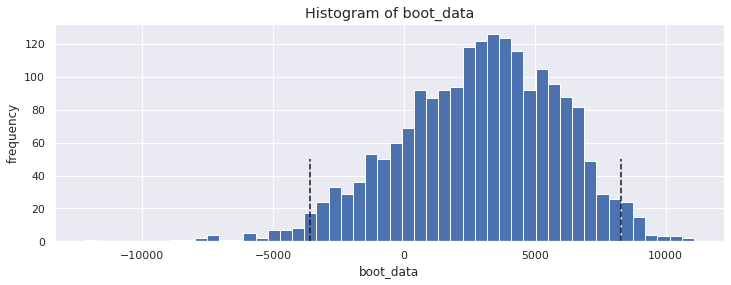

p_value: 0.3567
ДИ:              0
0.025 -3583.60
0.975  8307.32


In [98]:
# проверка гипотез в возростной группе младше 20 лет
sns.set(rc = {'figure.figsize':(12,4)})
x = users_all.query('total_revenue > 0 and group == "test" and age_group == "< 20"').total_revenue
y = users_all.query('total_revenue > 0 and age_group == "< 20" and (group == "control_1" or group == "control_2")').total_revenue
ARPPU_age = get_bootstrap(x, y, statistic = np.mean, boot_it = 2000)
print(f'p_value: {ARPPU_age["p_value"].round(5)}')
print(f'ДИ: {ARPPU_age["ci"].round(2)}')

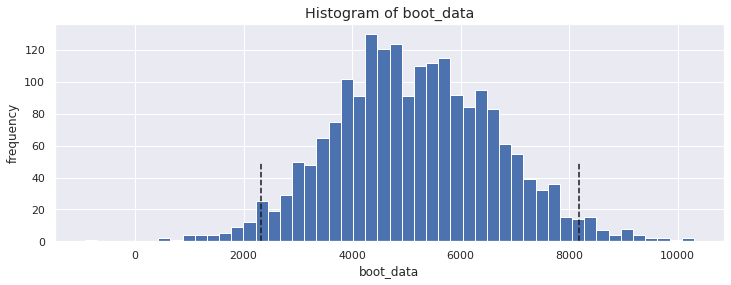

p_value: 0.00061
ДИ:              0
0.025  2318.45
0.975  8184.89


In [99]:
# проверка гипотез в возростной группе от 20 до 30 лет
sns.set(rc = {'figure.figsize':(12,4)})
x = users_all.query('total_revenue > 0 and group == "test" and age_group == "20-30"').total_revenue
y = users_all.query('total_revenue > 0 and age_group == "20-30" and (group == "control_1" or group == "control_2")').total_revenue
ARPPU_age = get_bootstrap(x, y, statistic = np.mean, boot_it = 2000)
print(f'p_value: {ARPPU_age["p_value"].round(5)}')
print(f'ДИ: {ARPPU_age["ci"].round(2)}')

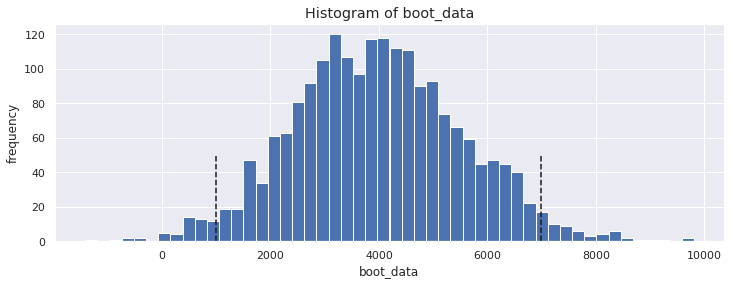

p_value: 0.01063
ДИ:              0
0.025   991.38
0.975  6994.59


In [100]:
# проверка гипотез в возростной группе от 31 до 40 лет
sns.set(rc={'figure.figsize':(12,4)})
x = users_all.query('total_revenue > 0 and group == "test" and age_group == "31-40"').total_revenue
y = users_all.query('total_revenue > 0 and age_group == "31-40" and (group == "control_1" or group == "control_2")').total_revenue
ARPPU_age = get_bootstrap(x, y, statistic=np.mean, boot_it = 2000)
print(f'p_value: {ARPPU_age["p_value"].round(5)}')
print(f'ДИ: {ARPPU_age["ci"].round(2)}')

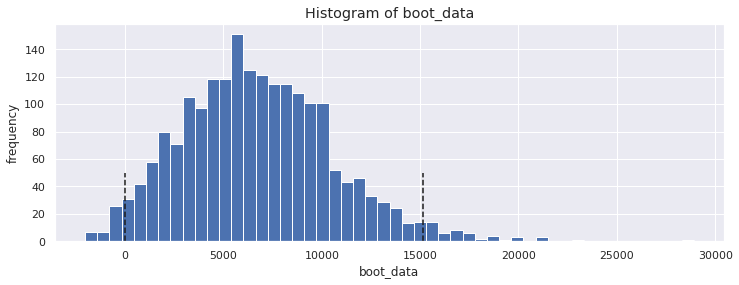

p_value: 0.08113
ДИ:               0
0.025     -3.14
0.975  15133.28


In [101]:
# проверка гипотез в возростной группе от 41 до 50 лет
sns.set(rc = {'figure.figsize':(12,4)})
x = users_all.query('total_revenue > 0 and group == "test" and age_group == "41-50"').total_revenue
y = users_all.query('total_revenue > 0 and age_group == "41-50" and (group == "control_1" or group == "control_2")').total_revenue
ARPPU_age = get_bootstrap(x, y, statistic = np.mean, boot_it = 2000)
print(f'p_value: {ARPPU_age["p_value"].round(5)}')
print(f'ДИ: {ARPPU_age["ci"].round(2)}')

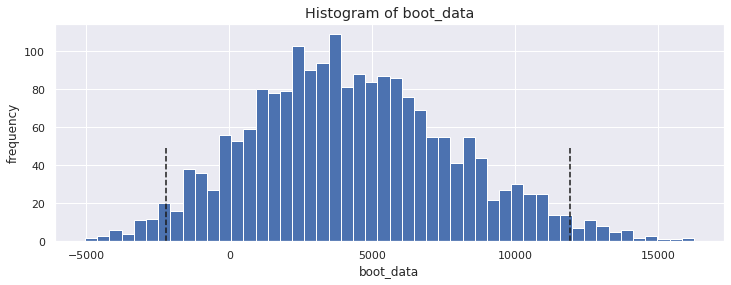

p_value: 0.23225
ДИ:               0
0.025  -2206.57
0.975  11900.22


In [102]:
# проверка гипотез в возростной группе старше 51 года
sns.set(rc = {'figure.figsize':(12,4)})
x = users_all.query('total_revenue > 0 and group == "test" and age_group == "=>51"').total_revenue
y = users_all.query('total_revenue > 0 and age_group == "=>51" and (group == "control_1" or group == "control_2")').total_revenue
ARPPU_age = get_bootstrap(x, y, statistic = np.mean, boot_it = 2000)
print(f'p_value: {ARPPU_age["p_value"].round(5)}')
print(f'ДИ: {ARPPU_age["ci"].round(2)}')

 Итоги проверки гипотез: 
* младше 20 лет - не можем отклонить Н0, ARPPU статистически значимо не отличается  
* от 20 до 30 лет - отклоняем Н0, ARPPU статистически значимо отличается  
* от 31 до 40 лет - отклоняем Н0, ARPPU статистически значимо отличается  
* от 41 до 50 лет - не можем отклонить Н0, ARPPU статистически значимо не отличается  
* старше 51 года - не можем отклонить Н0, ARPPU статистически значимо не отличается  

Нововведение оказало положительный эффект на показатель ARPPU в возростных группах от 20 до 30 лет и от 31 до 40 лет. Так, показатель ARPPU вырос в 1,5 раза в возростной группе от 20 до 30 лет и в 1,3 раза в возростной группе от 31 до 40 лет.

In [103]:
# для удобства присоединим столбец с типом продукта к основной таблице с информацией о пользователях
df_CRp = users_all.merge(transactions_all[['uid','product_type']], on = 'uid')
df_CRp.head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,group,purchase,premium,cr,group_t_c,age_group,product_type
0,891152790,29,769,0.0,Spain,"2,5,6",1,16,32,13,1.0,1.0,12597,test,True,True,1,test,20-30,premium_no_trial
1,892333656,50,436,4.0,United States of America,"1,2,3,4",1,47,53,126,0.0,0.0,897,test,True,False,1,test,41-50,coins
2,891589239,21,303,37.0,Italy,"1,2,3,4,5,6,7,8,9",1,18,24,181,1.0,1.0,37817,test,True,True,1,test,20-30,coins
3,891589239,21,303,37.0,Italy,"1,2,3,4,5,6,7,8,9",1,18,24,181,1.0,1.0,37817,test,True,True,1,test,20-30,coins
4,891589239,21,303,37.0,Italy,"1,2,3,4,5,6,7,8,9",1,18,24,181,1.0,1.0,37817,test,True,True,1,test,20-30,premium_no_trial


Проверка гипотез критерием хи-квадрат тестом:
- Н0 - изменение цены подписки в веденных платежных системах не влияет на факт покупки премиум подписки      
- Н1 - изменение цены подписки в веденных платежных системах влияет на факт покупки премиум подписки  

Критерий значимости: p > 0.05 - не можем отвергнуть H0, значимых статистических различий не выявлено

In [104]:
# подготовим df для дальнейшего анализа CRp в возрастной группе младше 20 лет
users_by_groups_age = df_CRp.query('age_group == "< 20"')
users_age_crp = pd.crosstab(users_by_groups_age.premium, users_by_groups_age.group)
users_age_crp

group,control_1,control_2,test
premium,,,
False,6,10,3
True,7,4,8


In [105]:
# хи-квадрат тест
stat, p, dof, expected = chi2_contingency(users_age_crp)
p

0.08538887461188881

In [106]:
# подготовим df для дальнейшего анализа CRp (объединенная контрольная группа)
users_by_groups_age = df_CRp.query('age_group == "< 20"')
users_age_crp = pd.crosstab(users_by_groups_age.premium, users_by_groups_age.group_t_c)
users_age_crp

group_t_c,control_1_2,test
premium,,
False,16,3
True,11,8


In [107]:
# хи-квадрат тест (объединенная контрольная группа)
stat, p, dof, expected = chi2_contingency(users_age_crp)
p

0.15249261169273606

По итогам проверки гипотез мы не можем отклонить H0 в возрастной группе менее 20 лет уровень значимости p > 0.05, т.е. статистически значимых различий не было выявлено.

In [108]:
# подготовим df для дальнейшего анализа CRp в возрастной группе 20-30 лет
users_by_groups_age = df_CRp.query('age_group == "20-30"')
users_age_crp = pd.crosstab(users_by_groups_age.premium, users_by_groups_age.group)
users_age_crp

group,control_1,control_2,test
premium,,,
False,51,51,52
True,109,99,38


In [109]:
# хи-квадрат тест
stat, p, dof, expected = chi2_contingency(users_age_crp)
p

0.00010232029883707566

In [110]:
# подготовим df для дальнейшего анализа CRp (объединенная контрольная группа)
users_by_groups_age = df_CRp.query('age_group == "20-30"')
users_age_crp = pd.crosstab(users_by_groups_age.premium, users_by_groups_age.group_t_c)
users_age_crp

group_t_c,control_1_2,test
premium,,
False,102,52
True,208,38


In [111]:
# хи-квадрат тест (объединенная контрольная группа)
stat, p, dof, expected = chi2_contingency(users_age_crp)
p

3.379029552272589e-05

По итогам проверки гипотез мы можем отклонить H0 в возрастной группе от 20-30 лет, т.е. при сравнении тестовой и контрольных групп по отдельности можно увидеть небольшое влияние на показатель конверсии. Но если сравнивать, тестовую и объединенную контрольную группу, то тут обратная ситуация и мы смело можем отклонять H0.

In [112]:
# подготовим df для дальнейшего анализа CRp в возрастной группе 31-40 лет
users_by_groups_age = df_CRp.query('age_group == "31-40"')
users_age_crp = pd.crosstab(users_by_groups_age.premium, users_by_groups_age.group)
users_age_crp

group,control_1,control_2,test
premium,,,
False,29,35,45
True,39,50,48


In [113]:
# хи-квадрат тест
stat, p, dof, expected = chi2_contingency(users_age_crp)
p

0.5942487079160028

In [114]:
# подготовим df для дальнейшего анализа CRp (объединенная контрольная группа)
users_by_groups_age = df_CRp.query('age_group == "31-40"')
users_age_crp = pd.crosstab(users_by_groups_age.premium, users_by_groups_age.group_t_c)
users_age_crp

group_t_c,control_1_2,test
premium,,
False,64,45
True,89,48


In [115]:
# хи-квадрат тест (объединенная контрольная группа)
stat, p, dof, expected = chi2_contingency(users_age_crp)
p

0.3834544182315597

По итогам проверки гипотез мы не можем отклонить H0 в возрастной группе 31 - 40 лет уровень значимости p > 0.05, т.е. статистически значимых различий не было выявлено.

In [116]:
# подготовим df для дальнейшего анализа CRp в возрастной группе 41-50 лет
users_by_groups_age = df_CRp.query('age_group == "41-50"')
users_age_crp = pd.crosstab(users_by_groups_age.premium, users_by_groups_age.group)
users_age_crp

group,control_1,control_2,test
premium,,,
False,28,32,12
True,15,13,14


In [117]:
# хи-квадрат тест
stat, p, dof, expected = chi2_contingency(users_age_crp)
p

0.10409386302267026

In [118]:
# подготовим df для дальнейшего анализа CRp (объединенная контрольная группа)
users_by_groups_age = df_CRp.query('age_group == "41-50"')
users_age_crp = pd.crosstab(users_by_groups_age.premium, users_by_groups_age.group_t_c)
users_age_crp

group_t_c,control_1_2,test
premium,,
False,60,12
True,28,14


In [119]:
# хи-квадрат тест (объединенная контрольная группа)
stat, p, dof, expected = chi2_contingency(users_age_crp)
p

0.06961101880074493

По итогам проверки гипотез мы не можем отклонить H0 в возрастной группе 41 - 50 лет уровень значимости p > 0.05, т.е. статистически значимых различий не было выявлено.

In [120]:
# подготовим df для дальнейшего анализа CRp в возрастной группе старше 50 лет
users_by_groups_age = df_CRp.query('age_group == "=>51"')
users_age_crp = pd.crosstab(users_by_groups_age.premium, users_by_groups_age.group)
users_age_crp

group,control_1,control_2,test
premium,,,
False,4,3,6
True,8,15,10


In [121]:
# хи-квадрат тест
stat, p, dof, expected = chi2_contingency(users_age_crp)
p

0.36432370404358266

In [122]:
# подготовим df для дальнейшего анализа CRp (объединенная контрольная группа)
users_by_groups_age = df_CRp.query('age_group == "=>51"')
users_age_crp = pd.crosstab(users_by_groups_age.premium, users_by_groups_age.group_t_c)
users_age_crp

group_t_c,control_1_2,test
premium,,
False,7,6
True,23,10


In [123]:
# хи-квадрат тест (объединенная контрольная группа)
stat, p, dof, expected = chi2_contingency(users_age_crp)
p

0.5012162872935633

 По итогам проверки гипотез мы не можем отклонить H0 в возрастной группе более 50 лет уровень значимости p > 0.05, т.е. статистически значимых различий не было выявлено.

Тенденция к снижению показателя конверсии в премиум подписку наблюдается во всех возрастных группах, которые пользуются обновлением. Только в возрастной группе от 20 до 30 лет конверсия относительно не меняется при сравнении тестовой и 2-й контрольной группы.

### Проверка в зависимости от гендерной принадлежности

 Проверка гипотез методом бутстрап-анализа:
- Н0 - изменение цены подписки в веденных платежных системах не влияет на ARPPU (средний доход на платящего пользователя)
- Н1 - изменение цены подписки в веденных платежных системах влияет на ARPPU (средний доход на платящего пользователя)

Критерий значимости: p > 0.05 - не можем отвергнуть H0, значимых статистических различий не выявлено

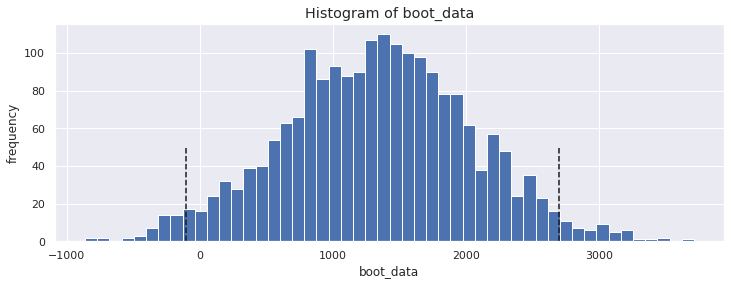

p_value: 0.05902
ДИ:              0
0.025  -103.02
0.975  2700.22


In [124]:
# проверка гипотез среди мужчин
sns.set(rc = {'figure.figsize':(12,4)})
x = users_all.query('total_revenue > 0 and gender == 1').total_revenue
y = users_all.query('total_revenue > 0 and gender == 1 and (group == "control_1" or group == "control_2")').total_revenue
ARPPU_gender = get_bootstrap(x, y, statistic = np.mean, boot_it = 2000)
print(f'p_value: {ARPPU_gender["p_value"].round(5)}')
print(f'ДИ: {ARPPU_gender["ci"].round(2)}')

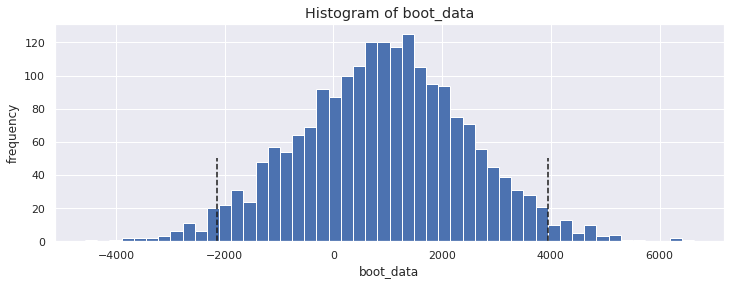

p_value: 0.55616
ДИ:              0
0.025 -2137.37
0.975  3943.08


In [125]:
# проверка гипотез среди женщин
sns.set(rc = {'figure.figsize':(12,4)})
x = users_all.query('total_revenue > 0 and gender == 0').total_revenue
y = users_all.query('total_revenue > 0 and gender == 0 and (group == "control_1" or group == "control_2")').total_revenue
ARPPU_gender = get_bootstrap(x, y, statistic = np.mean, boot_it = 2000)
print(f'p_value: {ARPPU_gender["p_value"].round(5)}')
print(f'ДИ: {ARPPU_gender["ci"].round(2)}')

Статистически значимых отклонений в распределении групп по гендерному признаку и эффекту на показатель ARPPU не выявлено.

### Проверка в зависимости от географического положения

In [126]:
# находим ARPPU стран, которые присутствуют в тестовой группе
group_by_countries = users_all.query('total_revenue > 0') \
                              .groupby(['country', 'group'], as_index = False) \
                              .agg({'total_revenue' : 'mean'}) \
                              .rename(columns = {'total_revenue': 'ARPPU'}) \
                              .pivot (index = 'country', columns = 'group', values = 'ARPPU') \
                              .sort_values('test', ascending = False) \
                              .query('test > 0')\
                              .fillna(0) \
                              .reset_index()\
                              .round(1)

group_by_countries

group,country,control_1,control_2,test
0,Argentina,12352.4,12101.7,26859.9
1,United Arab Emirates,10791.9,23428.6,23753.9
2,France,7878.6,7845.8,19894.3
3,Israel,8041.0,11770.2,19607.2
4,Spain,11006.7,16148.2,19028.5
5,Chile,9756.5,9874.1,17485.0
6,Belgium,11407.5,11021.4,15671.5
7,Germany,4799.6,14281.8,13728.0
8,Italy,7714.6,7274.4,12602.8
9,Australia,6101.3,11323.0,12597.0


In [127]:
 # создаем список со странами из тестовой группы
group_by_countries_test = group_by_countries.query('test > 0').country.tolist()
group_by_countries_test

['Argentina',
 'United Arab Emirates',
 'France',
 'Israel',
 'Spain',
 'Chile',
 'Belgium',
 'Germany',
 'Italy',
 'Australia',
 'United States of America',
 'Canada',
 'United Kingdom (Great Britain)',
 'Turkey',
 'Switzerland',
 'Mexico']

In [128]:
# создаем столбец, где будет отражена информация об использовании премиум подписки
uid_premium_no_trial = df_CRp.query('product_type == "premium_no_trial"').uid.unique()
df_CRp['premium_no_trial'] = df_CRp.uid.isin(uid_premium_no_trial)
df_CRp

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,...,is_premium,total_revenue,group,purchase,premium,cr,group_t_c,age_group,product_type,premium_no_trial
0,891152790,29,769,0.0,Spain,"2,5,6",1,16,32,13,...,1.0,12597,test,True,True,1,test,20-30,premium_no_trial,True
1,892333656,50,436,4.0,United States of America,"1,2,3,4",1,47,53,126,...,0.0,897,test,True,False,1,test,41-50,coins,False
2,891589239,21,303,37.0,Italy,"1,2,3,4,5,6,7,8,9",1,18,24,181,...,1.0,37817,test,True,True,1,test,20-30,coins,True
3,891589239,21,303,37.0,Italy,"1,2,3,4,5,6,7,8,9",1,18,24,181,...,1.0,37817,test,True,True,1,test,20-30,coins,True
4,891589239,21,303,37.0,Italy,"1,2,3,4,5,6,7,8,9",1,18,24,181,...,1.0,37817,test,True,True,1,test,20-30,premium_no_trial,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
839,891452592,49,127,0.0,France,"1,2,3,4,5,6,7,8,9,10,11,12",1,39,48,837,...,1.0,15626,control_2,True,False,1,control_1_2,41-50,trial_premium,False
840,891213609,26,363,0.0,United States of America,0,1,23,29,11,...,1.0,6292,control_2,True,True,1,control_1_2,20-30,premium_no_trial,True
841,891937068,26,214,16.0,Portugal,"1,2,3,4,5,6,7,8",1,19,49,14,...,0.0,6045,control_2,True,True,1,control_1_2,20-30,coins,True
842,891937068,26,214,16.0,Portugal,"1,2,3,4,5,6,7,8",1,19,49,14,...,0.0,6045,control_2,True,True,1,control_1_2,20-30,coins,True


 Проверка гипотез хи-квадрат тестом:
 - Н0 - изменение цены подписки в веденных платежных системах не влияет на факт покупки
 - Н1 - изменение цены подписки в веденных платежных системах влияет на факт покупки  

Критерий значимости: p > 0.05 - не можем отвергнуть H0, значимых статистических различий не выявлено (исключение Мексика)

In [129]:
# тест хи-квадрат, проверка гипотез по географическому положению
p_countries = []
for i in group_by_countries_test:
    value = df_CRp.query("country == @i")
    stat, p, dof, expected = chi2_contingency(pd.crosstab(value.premium_no_trial, value.group))
    p_countries.append(p)
p_countries_group = pd.DataFrame({'country': group_by_countries_test, 'p_value': p_countries})
p_countries_group.sort_values('p_value')

,country,p_value
8,Italy,0.000002
4,Spain,0.000147
3,Israel,0.000164
12,United Kingdom (Great Britain),0.001369
13,Turkey,0.002479
10,United States of America,0.005069
14,Switzerland,0.005749
5,Chile,0.011719
7,Germany,0.042015
11,Canada,0.202283


ARPPU статистически различен между тестовой и контрольными группами. В 10 странах наблюдаются статистически значимые различия, т.е. нововведение можно обкатывать на пользователях таких стран, как Мексика, Италия, Испания, Израиль, Великобритания, Турция, США, Швейцария, Чили и Германия.

## Вывод по работе

 В работе представлен полный анализ запуска нововведения, в рамках которого для новых пользователей из нескольких стран была изменена стоимость премиум-подписки при покупке через две новые платежные системы. В эксперименте принимали участие пользователи, зарегистрированные в дейтинговом приложении с 11 января 2017 года по 31 октября 2017 года, которые могли проводить транзакции с 11 января 2017 года по 11 декабря 2017 года.  
 \
 Группы пользователей по социальной идентичности распределены равномерно, что говорит о репрезентативности выборок. Проверка сплитования показала, что в исследуемых группах соблюдаются все необходимые пропорции, что говорит об объективности результатов тестирования и корректной работе системы сплитования (АА-тест).  

Для оценки успешности эксперимента были использованы метрики:
- Конверсия из пользователя в покупателя (CR)
- Конверсия из пользователя в покупателя премиум подписки (CRp)
- Средний доход на пользователя (ARPU)
- Средний доход на платящего пользователя (ARPPU)  

Оценка метрик до проведения АБ-тестов показала, что эксперимент вполне успешен и можно говорить о его запуске в продакшн, так:
- Среднее число покупок на одного клиента (APC) увеличилось на 3,5%. Следовательно, наблюдается положительная динамика и по среднему чеку (AvPrice), так средний чек контрольных групп вырос на 2500 ед.
- Выручка приложения увеличилась примерно на 15%.
- Средний доход на пользователя (ARPU) и средний доход на платящего пользователя (ARPPU) также существенно выросли, примерно в 1,5 раза.

Но для формирования более корректных выводов было принято решение об оценке статистической значимости нововведения. Так, проведенное АБ-тестирование показало, что после увеличения цен на подписку значительно снизилась конверсия в покупку (в частности в премиум подписку), но при этом имеем статистически значимое увеличение ARPPU. Показатель ARPU в тестовой группе выше чем в контрольных, но по итогам тестов можно сказать, что значимо не изменился. Как следствие, было рекомендовано не раскатывать обновление на всю группу, а проверить на какие группы пользователей оно оказывает наибольший эффект.

Анализ пользователей в разрезе различных подгрупп позволяет сделать вывод, что нововведение имеет смысл:
- для пользователей от 20 до 40 лет, аудитория данного возрастного сегмента является самой большой по размеру, показатель ARPPU существенно растет, также стоит отметить, что конверсия в покупку не имеет прогрессирующей отрицательной динамики. Это говорит об успешности эксперимента на данном сегменте.  
- для пользователей из таких стран, как Мексика (пользователи из Мексики оформили премиум подписку только после нововведения в тестовой группе), Италия, Испания, Израиль, Великобритания, Турция, США, Швейцария, Чили и Германия (в данных странах показатель ARPPU статистически различен между тестовой и контрольными группами).

Катим идею в фичу для вышеперечисленных групп.

Стоит отметить, что необходимо проводить постоянный мониторинг метрик приложения, так как прослеживается тенденция к постоянной отрицательной динамике показателя конверсии в любую покупку.